<a href="https://colab.research.google.com/github/HigherGround189/EGT309-Team-Harish-Kanna/blob/main/notebooks/Jun_Hoe_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [355]:
import sqlite3
from typing import Any, Tuple, Union

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE
from missmecha.analysis import MCARTest
from scipy.stats import chi2_contingency
from sklearn.feature_selection import (
    SelectKBest,
    SelectPercentile,
    mutual_info_classif,
)
from sklearn.impute import KNNImputer
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**!Note!** If some graphs does not display, please run the whole jupyter notebook or specific cells for graphs to load

In [356]:
con = sqlite3.connect("../data/01_raw/bmarket.db")  # Connect to bmarket.db database
cursor = con.cursor()

In [357]:
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
for row in cursor.fetchall():  # Check for all tables in database
    print(row)

('bank_marketing',)


In [358]:
query = "SELECT * FROM bank_marketing;"  # Retrieve data from bank_marketing table
df = pd.read_sql_query(query, con)
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


![IMAGE of attributes of bank marketing table](https://github.com/HigherGround189/EGT309-Team-Harish-Kanna/blob/main/EDA/images/bmarketing_attributes.png?raw=1)

## 1. Initiate Data Understanding and Insights

In [359]:
df

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no
...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6266,58 years,retired,married,professional.course,unknown,no,no,Telephone,2,999,no
41184,11285,37 years,management,married,university.degree,no,no,no,telephone,1,999,no
41185,38159,35 years,admin.,married,high.school,no,None,no,cellular,1,4,yes
41186,861,40 years,management,married,university.degree,no,None,no,telephone,2,999,no


In [360]:
df.info()
print("\nTable Size:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB

Table Size: (41188, 12)


In [361]:
df.isna().sum()

Client ID                    0
Age                          0
Occupation                   0
Marital Status               0
Education Level              0
Credit Default               0
Housing Loan             24789
Personal Loan             4146
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

In [362]:
df.duplicated().sum()

np.int64(0)

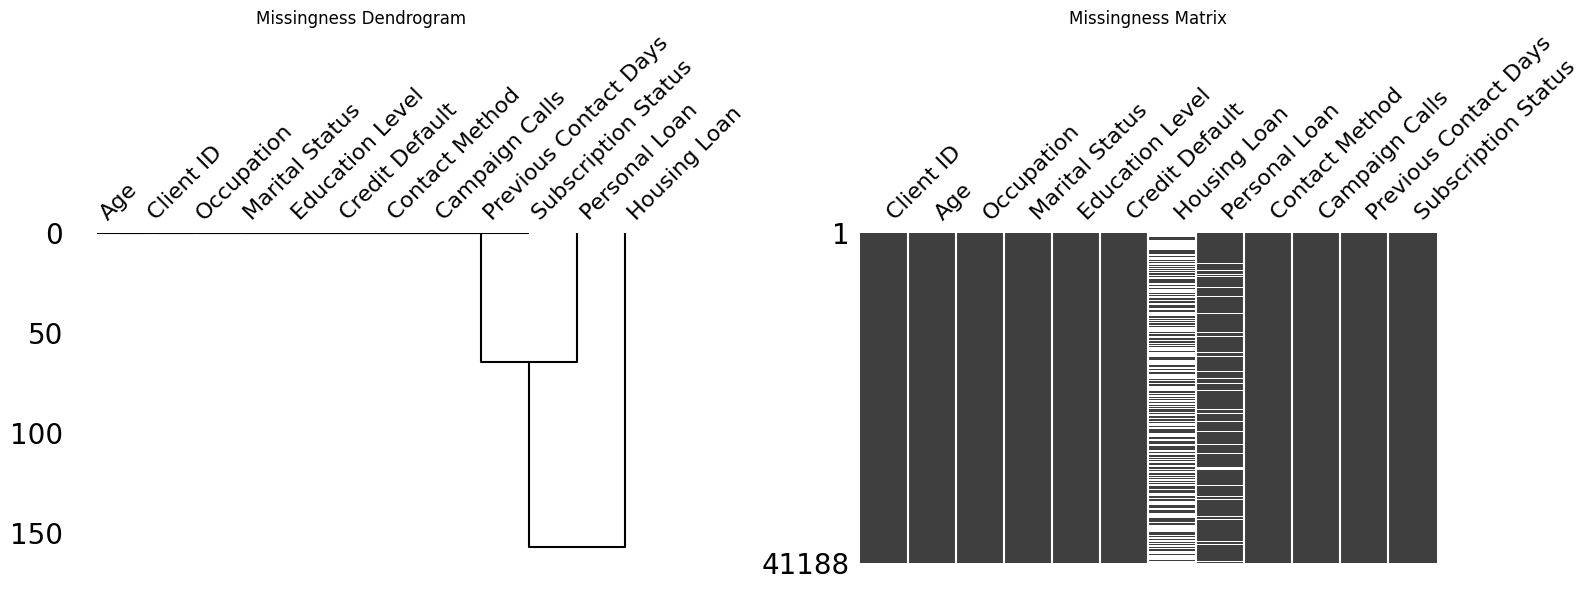

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

msno.dendrogram(df, ax=axes[0])
axes[0].set_title("Missingness Dendrogram")

msno.matrix(df, ax=axes[1], sparkline=False)
axes[1].set_title("Missingness Matrix")

plt.tight_layout()
plt.show()

> **OBSERVATION:**
___

- Reading the bank marketing table, the dataframe has **41188 rows** and **12 columns**.

- While observing the .info(), we can see that **`Client ID`**, **`Campaign Call`** and **`Previous Contact Days`** is assigned as *Integer* type. While the remaining columns are *Object* type.

- Furthermore, the .info() also shows that all of the columns has no empty values besides **Housing Loan (24789 missing data)** and **Personal Loan (4146 missing data)**.

- There is **no duplicated data** found.

- In addition, it is understandable that the `Personal Loan` and `Housing Loan` has a relationship in terms of missing values as shown in the dendrogram. Yet, they have a very far match to predict each other. Telling me that their missing values are not on the same row most of the time (Most likely due to the extreme sheer amount of missing data in Housing Loan).

- The `Subscription Status` column shows values of *yes* or *no* in string type instead of *True* or *False* in boolean type.

- Lastly, the values in `Age` column seems to **contains the text *years*** after all the numeric values, which is unnecessary. While `Education Level` column has a **two part format with a '.' between two key words** (e.g. high.school, univeristy.degree). The `Occupation` column has an **admin role that ended with '.'**.



> **THOUGHT PROCESS:**
___

1. A deeper observation into `Education Level` and `Occupation` columns is required to get a better understanding before cleaning.

2. I can remove *years* from the values in `Age` column and change the data type to *Integer*.

3. I can convert `Subscription Status` column into boolean type, with values of *True* or *False*, since the attribute says the column is defines as "Whether the client subscribed or not".


4. May consider dropping `Housing Loan` column since the missingno dendrogram and matrix shows an extremely high missingness.

Possible Hypothesis
___
- The table displayed shows signs of **missing data** in certain columns (e.g. `Occupation`, `Education Level`, `Credit Default`). These columns **were expected to have no empty values** based on previous statement. These missing values are refered to as *unknown*.

- If so, I need to replace all the *unknown* with *numpy NaN (np.nan)* to ensure all the missing data is captured.

#### Side Possibility 1a. Replace *unknown* and *None* with np.nan)

In [364]:
df_unknown_to_none = df.copy()
replace_with_nan = ["unknown", None]
df_unknown_to_none.replace(replace_with_nan, np.nan, inplace=True)
df_unknown_to_none.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             40858 non-null  object
 3   Marital Status         41108 non-null  object
 4   Education Level        39457 non-null  object
 5   Credit Default         32591 non-null  object
 6   Housing Loan           16006 non-null  object
 7   Personal Loan          36165 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [365]:
df_unknown_to_none.isna().sum()

Client ID                    0
Age                          0
Occupation                 330
Marital Status              80
Education Level           1731
Credit Default            8597
Housing Loan             25182
Personal Loan             5023
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

In [366]:
df_unknown_to_none.duplicated().sum()

np.int64(0)

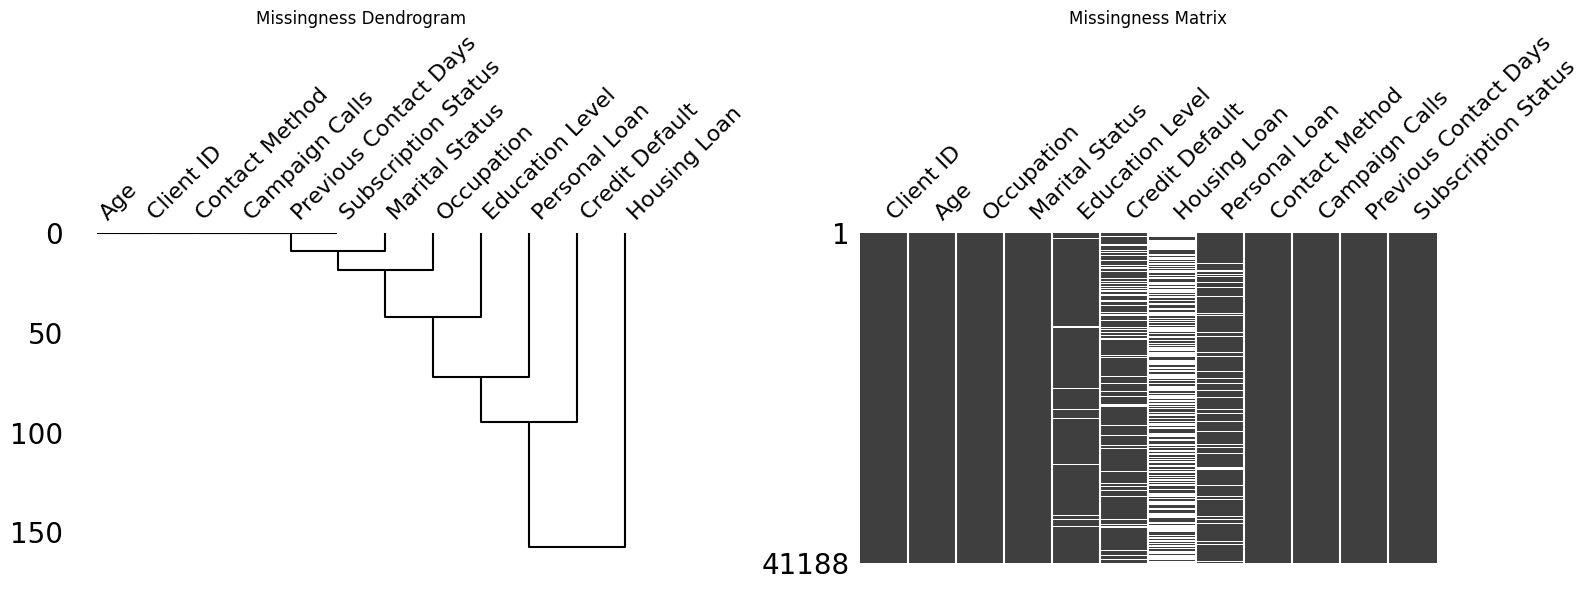

In [367]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

msno.dendrogram(df_unknown_to_none, ax=axes[0])
axes[0].set_title("Missingness Dendrogram")

msno.matrix(df_unknown_to_none, ax=axes[1], sparkline=False)
axes[1].set_title("Missingness Matrix")

plt.tight_layout()
plt.show()

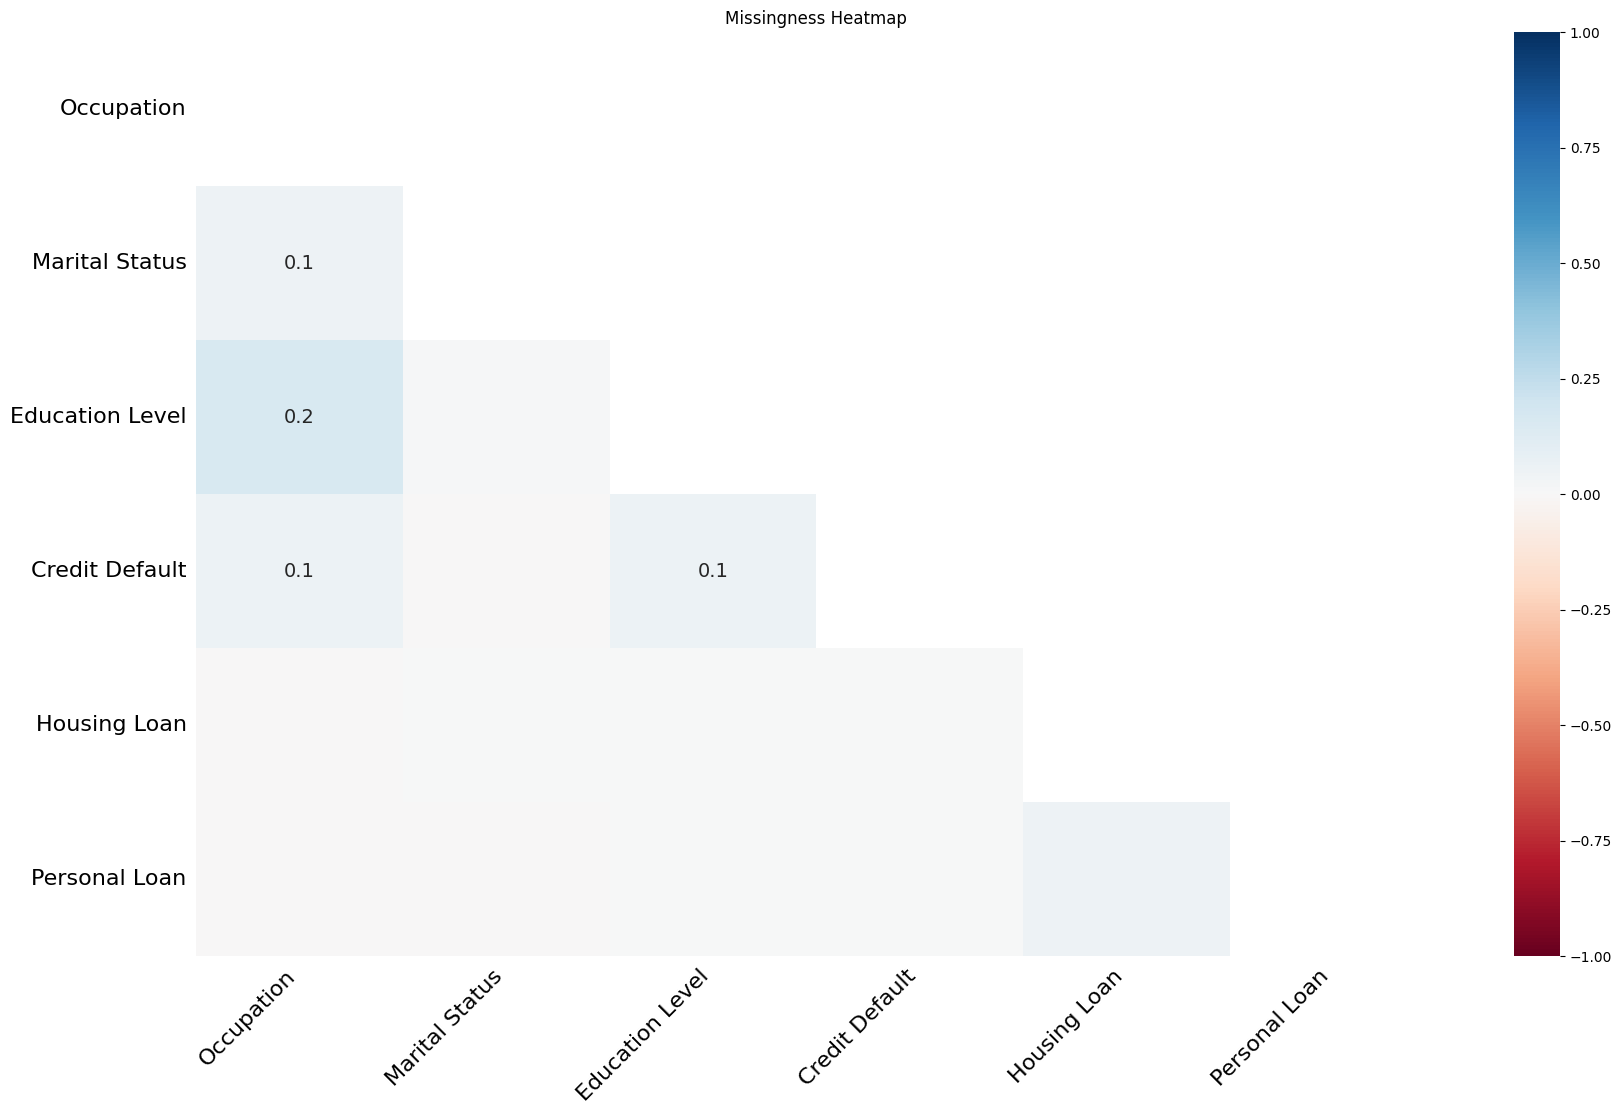

In [368]:
msno.heatmap(df_unknown_to_none)
plt.title("Missingness Heatmap")
plt.show()

> **Observation:**
___
- In this scenario of treating unknown as None, we can see that Housing Loan still has the furthest gap with the rest of columns in the dendrogram.

- Although in dendrogram, it shows a close relationship in missing values between some of the columns, the heatmap disagrees as all of them have a very low correlation
  - The highest correlation is 0.2 between Education Level and Occupation.
  - 3 of the correlation is 0.1
  - While the remaining are extremely close to 0.

> **Thought Process:**
___
1. This shows that methods like joint imputation or model-based imputation (if necessary) would not be helpful since there is very little correlation of the occurrence of missing values.

2. For very low missing values columns, we can drop the rows or impute them.

3. The ones with low missing values, will require independent imputation with techniques like simple imputation or random distribution imputation will suffice

4. High missing values may result in dropping the entire column.

#### Graph Plot Functions

In [369]:
def plot_bar_graph(
    df,
    col,
    y=None,
    kind="bar",
    figsize=(8, 5),
    top=None,
    title=None,
    ascending=False,
    x_rotation=0,
    legend=True,
    fontsize=9
):
    """
    Plot a bar graph for the input data.

    Parameters
    ----------
    df    : DataFrame
    col   : name of column for x-axis
    y     : name of column for y-axis (only for 'bar')
    kind: 'bar' (Default) or 'count'
      bar:    plot bar graph
      count:  plot count graph
    """
    if kind == "count":  # Count plot to display frequencies of each unique value
        counts = df[col].value_counts(ascending=ascending).reset_index()
        total = counts["count"].sum()
        # Calculate percentage of distribution of the values
        counts["label_text"] = counts.apply(
            lambda row: f"{row['count']} ({row['count'] / total * 100:.1f}%)",
            axis=1,
        )

        # To display top frequent unique values
        plot_df = counts if top is None else counts.head(top)

        bars = plt.bar(plot_df[col], plot_df["count"], color=sns.color_palette("pastel", len(plot_df)))
        for bar, label in zip(bars, plot_df["label_text"]):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), label,
                     ha='center', va='bottom', fontsize=fontsize)
        if legend:
            plt.legend(bars, plot_df[col].astype(str), title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

    elif kind == "bar":
        if y is None:  # To ensure y is provided to compare
            raise ValueError("y must be provided for barplot")
        # To display top frequent unique values
        plot_df = df if top is None else df.head(top)

        bars = plt.bar(plot_df[col].astype(str), plot_df[y], color=sns.color_palette("pastel", len(plot_df)), label=y if legend else None)
        for bar, val in zip(bars, plot_df[y]):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val}", 
                     ha='center', va='bottom', fontsize=9)
        if legend:
            plt.legend(bars, plot_df[col].astype(str), title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
            
    else:
        raise ValueError("kind must be 'bar' or 'count'")

    plt.title(title if title else f"{kind.capitalize()} plot of {col}")
    plt.xlabel(col)
    plt.ylabel(y if kind == "bar" else "Frequency")
    plt.xticks(rotation=x_rotation)
    plt.show()


def plot_hist_graph(
    df,
    col,
    bins=None,
    shrink=0,
    figsize=(8, 5),
    title=None,
    x_rotation=0,
):
    """
    Plot a histogram graph for the input data.

    Parameters
    ----------
    df    : DataFrame
    col   : name of column for x-axis
    bins  : number of bins for the historgram
    shrink: add gap between histogram bars
    """
    plt.figure(figsize=figsize)
    
    # Plot histogram
    sns.histplot(
        df[col],
        bins=bins,
        color="skyblue",
        edgecolor="black",
        linewidth=1.2,
        shrink=shrink
    )
    
    plt.xticks(rotation=x_rotation)
    
    plt.title(title if title else f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


def plot_box_graph(df, col, figsize=(8, 5), title=None, y_rotation=0):
    """
    Plot a box plot for the input data.

    Parameters
    ----------
    df    : DataFrame
    col   : name of column for x-axis
    """
    plt.figure(figsize=figsize)
    
    # Plot boxplot
    sns.boxplot(x=df[col])
    
    plt.title(title if title else f"Box Plot of {col}")
    plt.ylabel(col)
    plt.yticks(rotation=y_rotation)
    plt.show()

#### 1b. Understanding Column data by Columns and insights

##### `Client ID` Column

In [370]:
print("Number of unique values:", df["Client ID"].nunique())

Number of unique values: 41188


> **OBSERVATION:**
___

- All rows/entries are uniquely identified by the Client ID.
- No repeated Client ID throughout data.

> **THINKING PROCESS:**
___

1. `Client ID` column can be remove as it serves no predicting values and contribute to high dimensionality issue in input data.

##### `Age` Column

In [371]:
display(df["Age"].describe())
print("List all unique values:\n", df["Age"].sort_values().unique())

count         41188
unique           77
top       150 years
freq           4197
Name: Age, dtype: object

List all unique values:
 ['150 years' '17 years' '18 years' '19 years' '20 years' '21 years'
 '22 years' '23 years' '24 years' '25 years' '26 years' '27 years'
 '28 years' '29 years' '30 years' '31 years' '32 years' '33 years'
 '34 years' '35 years' '36 years' '37 years' '38 years' '39 years'
 '40 years' '41 years' '42 years' '43 years' '44 years' '45 years'
 '46 years' '47 years' '48 years' '49 years' '50 years' '51 years'
 '52 years' '53 years' '54 years' '55 years' '56 years' '57 years'
 '58 years' '59 years' '60 years' '61 years' '62 years' '63 years'
 '64 years' '65 years' '66 years' '67 years' '68 years' '69 years'
 '70 years' '71 years' '72 years' '73 years' '74 years' '75 years'
 '76 years' '77 years' '78 years' '79 years' '80 years' '81 years'
 '82 years' '83 years' '84 years' '85 years' '86 years' '88 years'
 '89 years' '91 years' '92 years' '95 years' '98 years']


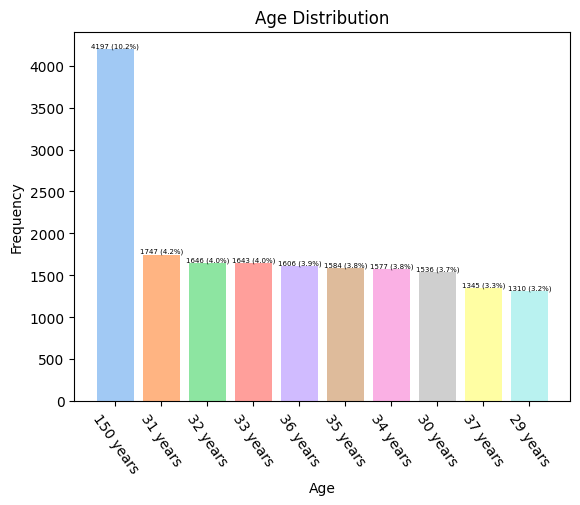

In [372]:
plot_bar_graph(
    df,
    col="Age",
    y="Frequency",
    kind="count",
    title="Age Distribution",
    top=10,
    x_rotation=-55,
    legend=False,
    fontsize=5
)

In [373]:
print(
    "Percentage of 150 years old: {:.5f}%".format(
        df[df["Age"] == "150 years"].shape[0] / df.shape[0] * 100
    )
)

Percentage of 150 years old: 10.18986%


> **OBSERVATION:**
___

- This is an Ratio Numeric
- "150 years" !!! Most likely a recorded error.
- The value "150 years" has the highest frequency by a large margin compared to other ages.
- The values in `Age` column do **contains the text *years*** after all the numeric values, which is a data type issue.

> **THINKING PROCESS**
___

- I can remove *years* from the values in `Age` column.
- Convert the data type to *Integer*.
- Plot histogram to get better insights.
- Possibly impute the "150 years" with simple imputation (mean or median)

##### `Occupation` Column

In [374]:
display(df["Occupation"].describe())
print("List all unique values:\n", df["Occupation"].sort_values().unique())

count      41188
unique        12
top       admin.
freq       10422
Name: Occupation, dtype: object

List all unique values:
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']


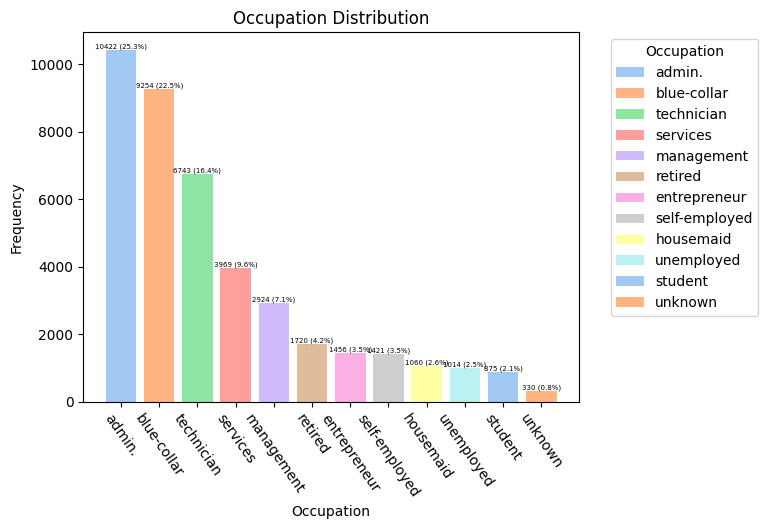

In [375]:
plot_bar_graph(
    df,
    col="Occupation",
    y="Frequency",
    kind="count",
    title="Occupation Distribution",
    x_rotation=-55,
    legend=True,
    fontsize=5
)

In [376]:
print(
    "Percentage of unknown: {:.2f}%".format(
        df[df["Occupation"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)

Percentage of unknown: 0.80%


> **Observation:**
___

- It is a Nominal Category
- Possible to one-hot or integer encode to feed into machine learning
- unknown only made out of 0.8% of the column.

> **THINKING PROCESS**
___

- unknown is only 0.8%, which is unlikely to give meaningful insights.
- Since it is small, we can afford to remove the row with the unknown in this column.


##### `Marital Status` Column

In [377]:
display(df["Marital Status"].describe())
print("List all unique values:\n", df["Marital Status"].sort_values().unique())

count       41188
unique          4
top       married
freq        24928
Name: Marital Status, dtype: object

List all unique values:
 ['divorced' 'married' 'single' 'unknown']


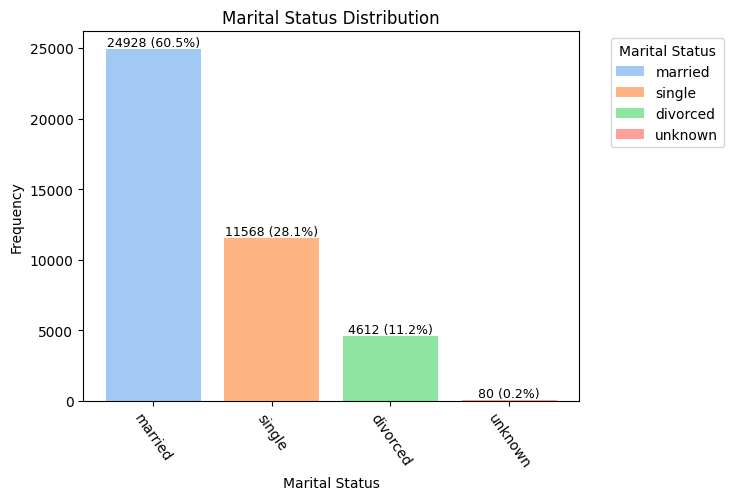

In [378]:
plot_bar_graph(
    df,
    col="Marital Status",
    y="Frequency",
    kind="count",
    title="Marital Status Distribution",
    x_rotation=-55,
    legend=True,
)

In [379]:
print(
    "Percentage of unknown: {:.2f}%".format(
        df[df["Marital Status"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)

Percentage of unknown: 0.19%


> **Observation:**
___

- This is a Nominal Category
- Most client are Married, second most are Singles
- The third are Divorced
- unknown only made out of 0.19% of the column.

> **THINKING PROCESS**
___

- unknown is only 0.19%, which is unlikely to give meaningful insights.
- Since this is smalle, we can afford to remove the row with the unknown in this column.

##### `Education Level` Column

In [380]:
display(df["Education Level"].describe())
print("List all unique values:\n", df["Education Level"].sort_values().unique())

count                 41188
unique                    8
top       university.degree
freq                  12168
Name: Education Level, dtype: object

List all unique values:
 ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree' 'unknown']


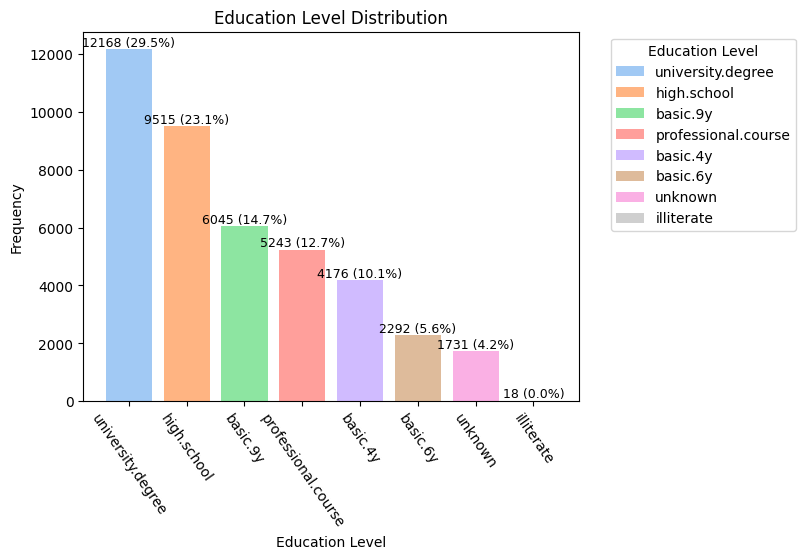

In [381]:
plot_bar_graph(
    df,
    col="Education Level",
    y="Frequency",
    kind="count",
    title="Education Level Distribution",
    x_rotation=-55,
    legend=True,
)

In [382]:
print(
    "Percentage of unknown: {:.2f}%".format(
        df[df["Education Level"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)

Percentage of unknown: 4.20%


> **Observation:**
___

- This is a Nominal Category
- Top are university, second highest is high school.
- Third is clients with 9 years of basic studies.
- unknown is made out of 4.2% in the column.

> **THINKING PROCESS**
___

- unknown is 4.2%, which contribute relatively high to the dataset. Therefore, it cannot be drop as it will lose meaningful insights.
- Should be treated as a category since it may provide informative insights.

##### `Credit Default` Column

In [383]:
display(df["Credit Default"].describe())
print("List all unique values:\n", df["Credit Default"].sort_values().unique())

count     41188
unique        3
top          no
freq      32588
Name: Credit Default, dtype: object

List all unique values:
 ['no' 'unknown' 'yes']


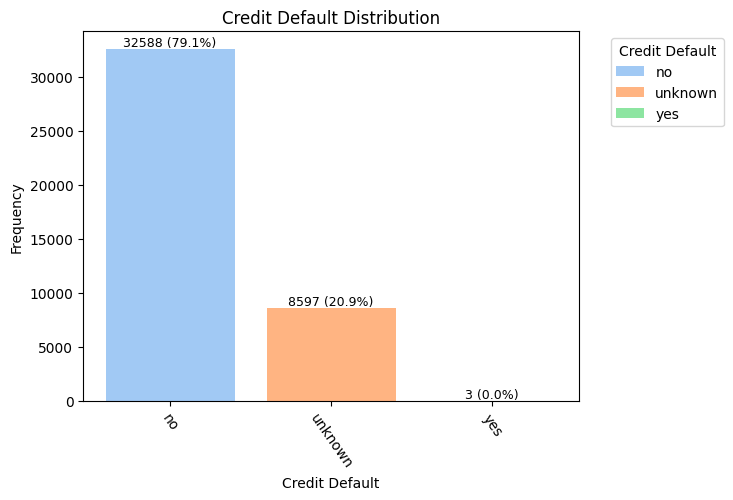

In [384]:
plot_bar_graph(
    df,
    col="Credit Default",
    y="Frequency",
    kind="count",
    title="Credit Default Distribution",
    x_rotation=-55,
    legend=True,
)

In [385]:
print(
    "Percentage of yes: {:.5f}%".format(
        df[df["Credit Default"] == "yes"].shape[0] / df.shape[0] * 100
    )
)
print(
    "Percentage of unknown: {:.5f}%".format(
        df[df["Credit Default"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)
print(
    "Percentage of no: {:.5f}%".format(
        df[df["Credit Default"] == "no"].shape[0] / df.shape[0] * 100
    )
)

Percentage of yes: 0.00728%
Percentage of unknown: 20.87258%
Percentage of no: 79.12013%


> **Observation:**
___

- This is a Nominal Category
- The amount of "yes" is way too little (only 3 rows) and most are "no" (80%).
- 20% is unknown, which shows no information.

> **THOUGHT PROCESS:**
___

- Can drop `Credit Default` column since majority disagree with credit default and only 0.007% agrees to it.
- Meaning it is severely imbalanced, where the column is unclassifiable.
- Especially, unknown made out of 20% which is also uninformative.

##### `Housing Loan` Column

In [386]:
display(df["Housing Loan"].describe())
print("List all unique values:\n", df["Housing Loan"].sort_values().unique())

count     16399
unique        3
top         yes
freq       8595
Name: Housing Loan, dtype: object

List all unique values:
 ['no' 'unknown' 'yes' None]


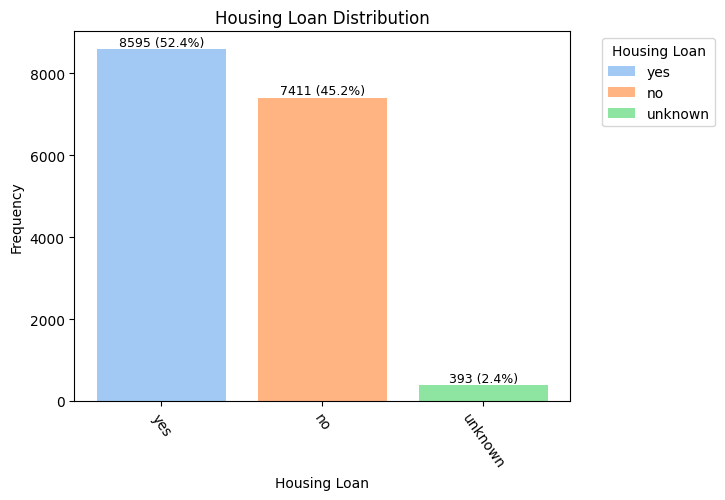

In [387]:
plot_bar_graph(
    df,
    col="Housing Loan",
    y="Frequency",
    kind="count",
    title="Housing Loan Distribution",
    x_rotation=-55,
    legend=True,
)

In [388]:
print(
    "Percentage of unknown (**include None in total frequency**): {:.5f}%".format(
        df[df["Housing Loan"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)
print(
    "Percentage of None: {:.5f}%".format(
        df[df["Housing Loan"].isna()].shape[0] / df.shape[0] * 100
    )
)

Percentage of unknown (**include None in total frequency**): 0.95416%
Percentage of None: 60.18501%


> **Observation:**
___

- This is a Nominal Category
- There is a very high percentage of missing values (60%) in the column.
- Excluding rows with None in Housing Loan column:
  - The number of "Yes" is the highest with 52.4% and "No" is second highest with 45.2%.
  - There is 2.4% of unknown which is the lowest.

> **THOUGHT PROCESS:**
___

- 60% is an extremely large gap for missing values.
- It may be the best to drop the entire column unless it can be imputed by other columns.

##### `Personal Loan` Column

In [389]:
display(df["Personal Loan"].describe())
print("List all unique values:\n", df["Personal Loan"].sort_values().unique())

count     37042
unique        3
top          no
freq      30532
Name: Personal Loan, dtype: object

List all unique values:
 ['no' 'unknown' 'yes' None]


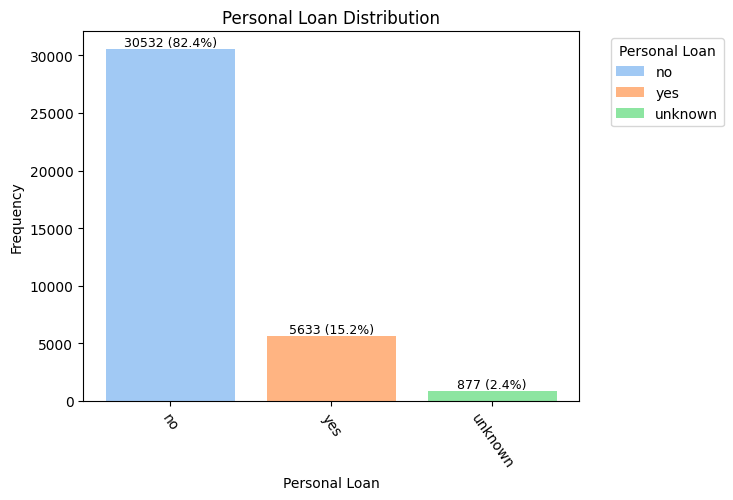

In [390]:
plot_bar_graph(
    df,
    col="Personal Loan",
    y="Frequency",
    kind="count",
    title="Personal Loan Distribution",
    x_rotation=-55,
    legend=True,
)

In [391]:
print(
    "Percentage of unknown (**include None in total frequency**): {:.5f}%".format(
        df[df["Personal Loan"] == "unknown"].shape[0] / df.shape[0] * 100
    )
)
print(
    "Percentage of None: {:.5f}%".format(
        df[df["Personal Loan"].isna()].shape[0] / df.shape[0] * 100
    )
)
print("Number of rows of None: {}".format(df[df["Personal Loan"].isna()].shape[0]))

Percentage of unknown (**include None in total frequency**): 2.12926%
Percentage of None: 10.06604%
Number of rows of None: 4146


> **Observation:**
___

- This is a Nominal Category
- There is a relatively low percentage of missing values (10%) in the column.
- Excluding rows with None in Personal Loan column
  - The number of "No" is the highest with 82.4% and "Yes" is second highest with 15.2%.
  - There is 2.4% of unknown which is the lowest.

> **THOUGHT PROCESS:**
___

- Although missing values make up of only 10%, dropping them may not be ideal as it represents quite a significant number of rows.
- Imputation could be a better approach to retain as much data as possible while handling missing entries.

##### `Contact Method` Column

In [392]:
display(df["Contact Method"].describe())
print("List all unique values:\n", df["Contact Method"].sort_values().unique())

count     41188
unique        4
top        Cell
freq      13100
Name: Contact Method, dtype: object

List all unique values:
 ['Cell' 'Telephone' 'cellular' 'telephone']


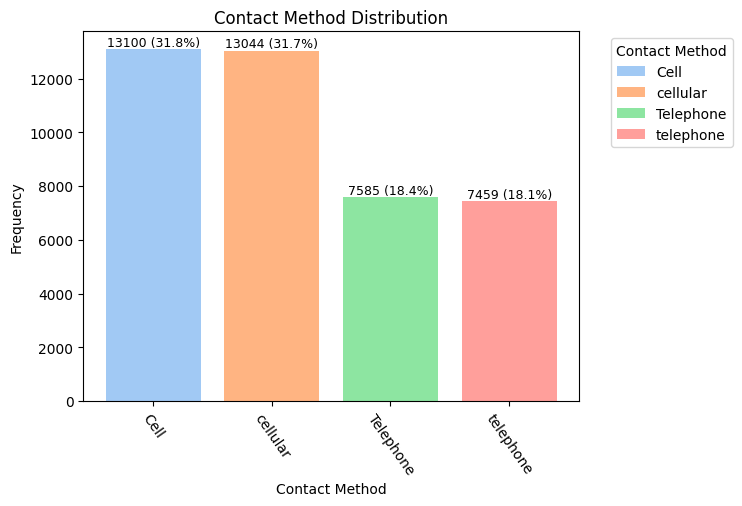

In [393]:
plot_bar_graph(
    df,
    col="Contact Method",
    y="Frequency",
    kind="count",
    title="Contact Method Distribution",
    x_rotation=-55,
    legend=True,
)

> **Observation:**
___

- This is a Nominal Category
- Repeated and inconsistent formats:
  - Cell and cellular
  - Telephone and telephone
- This is a Nominal category

> **THOUGHT PROCESS:**
___

- Replace all Cell with cellular
- Replace all Telephone with telephone

##### `Campaign Calls` Column

In [394]:
display(df["Campaign Calls"].describe())
print("List all unique values:\n", df["Campaign Calls"].sort_values().unique())

count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

List all unique values:
 [-41 -35 -32 -29 -28 -25 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12
 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  37  39  40  42  43  56]


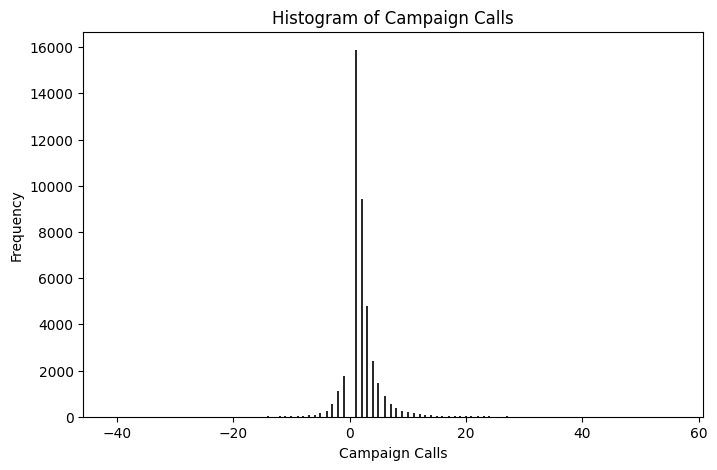

In [395]:
# Freedman–Diaconis rule
q75, q25 = np.percentile(df["Campaign Calls"], [75, 25])
bin_width = 2 * (q75 - q25) * len(df) ** (-1 / 3)
bins = int((df["Campaign Calls"].max() - df["Campaign Calls"].min()) / bin_width)

plot_hist_graph(df, col="Campaign Calls", bins=bins, x_rotation=0)

> **Observation:**
___

- This is a Ratio Numeric
- There is negative values in the column.
- There is a good and symmetric distribution from range -41 to 56, with a single peak at 1 calls.
- There is **No** 0 calls.

> **THOUGHT PROCESS:**
___

- Highly doubt that the negative values are valid:
  - The definition given is "*Total number* of contacts performed for this campaign and this client, including the last contact".
  - The calls are very evenly distributed, meaning that it is mirrored.
- Possible solution:
  1. Absolute the negative to turn to positive.
  2. Add another column to retain the negative meaning, together with Solution #1.


##### `Previous Contact Days` Column

In [396]:
display(df[df["Previous Contact Days"] != 999]["Previous Contact Days"].describe())
print("List all unique values:\n", df["Previous Contact Days"].sort_values().unique())

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: Previous Contact Days, dtype: float64

List all unique values:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  25  26  27 999]


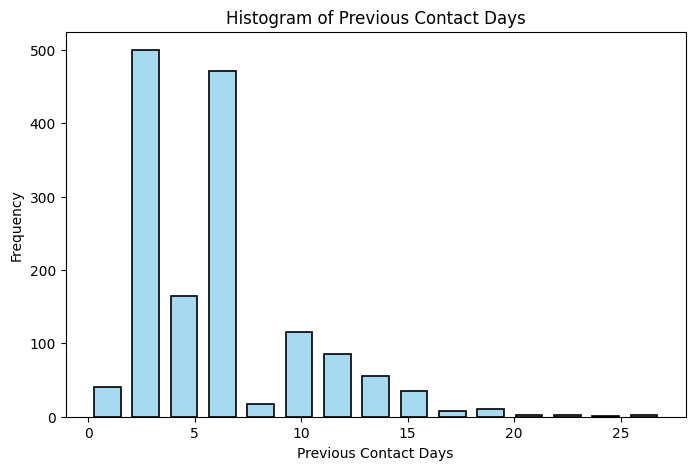

In [397]:
plot_hist_graph(
    df[df["Previous Contact Days"] != 999],
    col="Previous Contact Days",
    bins=15,
    shrink=0.7,
    x_rotation=0,
)

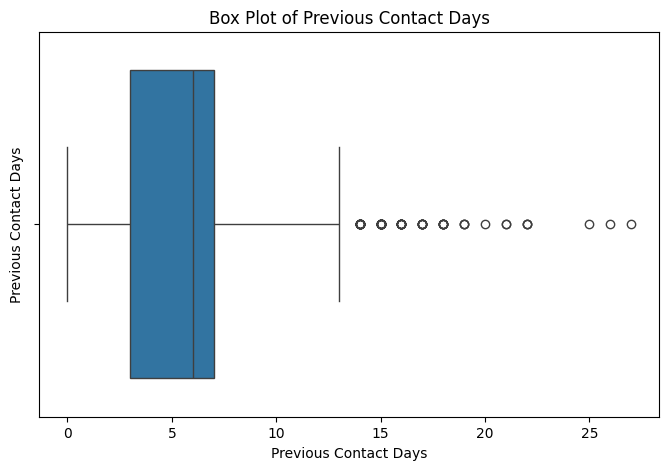

In [398]:
plot_box_graph(df[df["Previous Contact Days"] != 999], col="Previous Contact Days")

In [399]:
print(
    "Percentage of 999: {:.5f}%".format(
        df[df["Previous Contact Days"] == 999].shape[0] / df.shape[0] * 100
    )
)

Percentage of 999: 96.32174%


> **Observation:**
___

- This is a Ratio Numeric
- There has the highest number of occurences with 96%.
- 999 is way too big of a value to be plotted as well as for machine learning. Cannot be included into the histogram and box plot.
- Excluding 999:


> **THOUGHT PROCESS:**
___

- Replace 999 to -1 in order to maintain the no prior contact meaning.
- Add a boolean column for "got prior contact" or "no prior contact", as a feature, for AI model to understand meaning of -1 value. This prevents models, especially regression models, to treat -1 as a numeric value instead of category.


##### `Subscription Status` Column

In [400]:
display(df["Subscription Status"].describe())
print("List all unique values:\n", df["Subscription Status"].sort_values().unique())

count     41188
unique        2
top          no
freq      36548
Name: Subscription Status, dtype: object

List all unique values:
 ['no' 'yes']


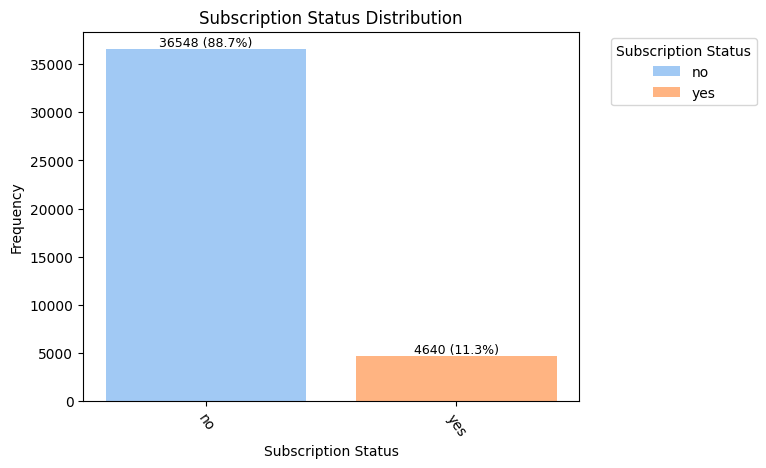

In [401]:
plot_bar_graph(
    df,
    col="Subscription Status",
    y="Frequency",
    kind="count",
    title="Subscription Status Distribution",
    x_rotation=-55,
    legend=True,
)

> **Observation:**
___

- This is a Nominal Category
- The column is very imbalance.

> **THOUGHT PROCESS:**
___

- Convert to Boolean data type
- Use Stratify when splitting the dataset for model training to ensure balance yes and no

## Data Preparation

#### Data Cleaning

##### Data Cleaning on `Client ID` Column

In [402]:
df.drop("Client ID", axis=1, inplace=True)  # Drop Client ID
df.head()

,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


##### Data Cleaning on `Age` Column

In [403]:
df["Age"] = df["Age"].map(lambda x: x.split()[0])  # Remove "years old" in Age column
df["Age"] = df["Age"].astype(int)
df["Age"]

0        57
1        55
2        33
3        36
4        27
         ..
41183    58
41184    37
41185    35
41186    40
41187    29
Name: Age, Length: 41188, dtype: int64

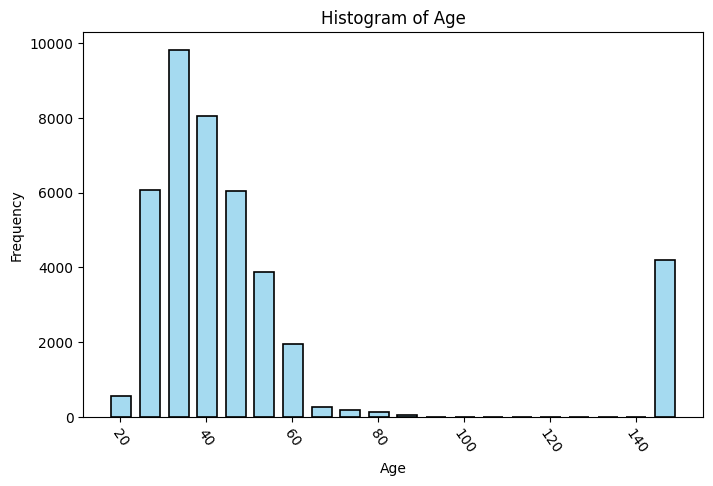

In [404]:
plot_hist_graph(df, col="Age", bins=20, shrink=0.7, x_rotation=-55)

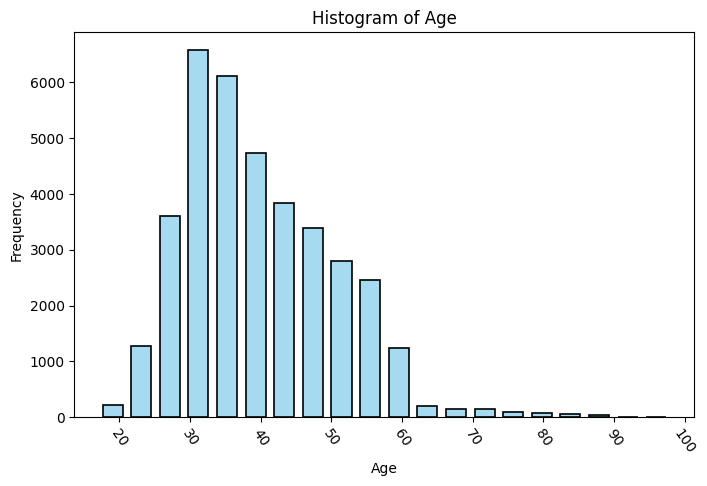

In [405]:
plot_hist_graph(
    df[df["Age"] != 150], col="Age", bins=20, shrink=0.7, x_rotation=-55
)

> **Observation:**
___

- There is a skew distribution of Age column (To the left).
- The outlier is 150, which is most likely an error, it also make up of about 4000 clients in the dataset.


> **THOUGHT PROCESS:**
___

- With large number of 150 in Age column, imputation need to be carried out instead of dropping.

##### Data Cleaning on `Occupation` Column

In [406]:
# Remove rows with unknown in Occupation column
df.drop(df[df["Occupation"] == "unknown"].index, axis=0, inplace=True)

# Display unique values in Occupation column
print("List all unique values:\n", df["Occupation"].sort_values().unique())
print("New Shape: ", df.shape)

List all unique values:
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed']
New Shape:  (40858, 11)


##### Data Cleaning on `Marital Status` Column

In [407]:
# Remove rows with unknown in Marital Status column
df.drop(df[df["Marital Status"] == "unknown"].index, axis=0, inplace=True)

# Display unique values in Marital Status column
print("List all unique values:\n", df["Marital Status"].sort_values().unique())
print("New Shape: ", df.shape)

List all unique values:
 ['divorced' 'married' 'single']
New Shape:  (40787, 11)


##### Data Cleaning on `Credit Default` Column

In [408]:
df.drop("Credit Default", axis=1, inplace=True)  # Drop Credit Default column
df.head()

,Age,Occupation,Marital Status,Education Level,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,57,technician,married,high.school,no,yes,Cell,1,999,no
2,33,blue-collar,married,basic.9y,no,no,cellular,1,999,no
3,36,admin.,married,high.school,no,no,Telephone,4,999,no
4,27,housemaid,married,high.school,None,no,Cell,2,999,no
5,58,retired,married,professional.course,None,yes,Cell,1,999,no


##### Data Cleaning on `Contact Method` Column

In [409]:
# Replace Cel with cell and Telephone with telephone
df["Contact Method"] = df["Contact Method"].map(
    lambda x: "cellular" if x[0].lower() == "c" else "telephone"
)

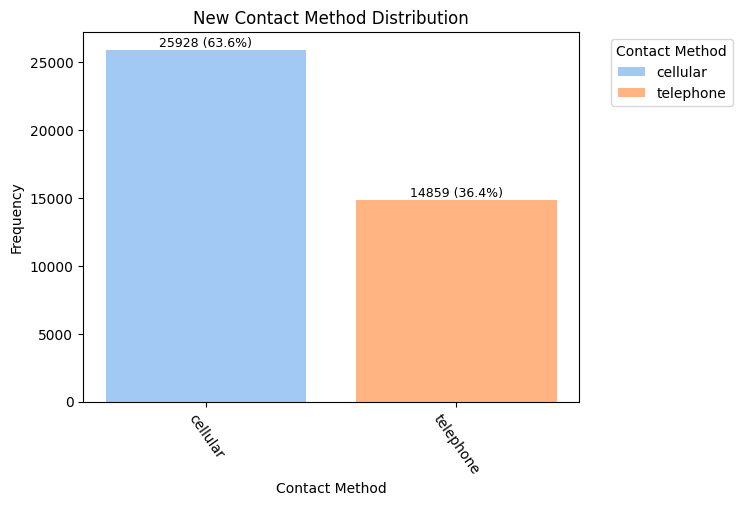

In [410]:
plot_bar_graph(
    df,
    col="Contact Method",
    y="Frequency",
    kind="count",
    title="New Contact Method Distribution",
    top=10,
    x_rotation=-55,
    legend=True,
)

> **Observation:**
___

- There is a higher number of client contacted by cellular (63.6%)
- The remaining are through telephone (36.4%)

> **THOUGHT PROCESS:**
___

- The dataset provided a good distribution of contact methods.

##### Data Cleaning on `Campaign Calls` Column

In [411]:
# Convert all negative values to positive
df["Campaign Calls"] = df["Campaign Calls"].apply(lambda x: abs(x))
display(df["Campaign Calls"].describe())
print("List all unique values:\n", df["Campaign Calls"].sort_values().unique())

count    40787.000000
mean         2.566112
std          2.768103
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

List all unique values:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 39 40 41 42 43 56]


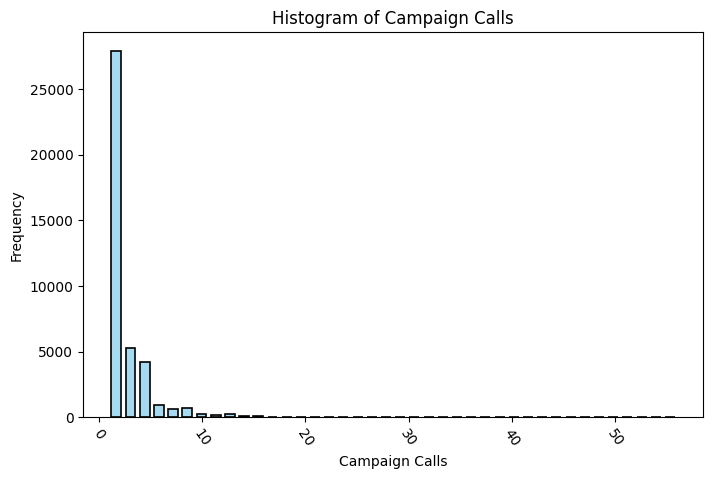

In [412]:
plot_hist_graph(df, col="Campaign Calls", bins=40, shrink=0.7, x_rotation=-55)

> **Observation:**
___

- The distribution of calls is extremely skew to the left.
- There is a outlier of 56 calls.

> **THOUGHT PROCESS:**
___

- Scaling may be needed for regression models in **model training** stage.

##### Data Cleaning on `Previously Contacted` Column

In [413]:
# Create Previously Contacted column where no prior call (999) means False and prior call mean True
df["Previously Contacted"] = df["Previous Contact Days"] != 999

# Replace no prior (999) with -1
df["Previous Contact Days"] = df["Previous Contact Days"].map(
    lambda x: -1 if x == 999 else x
)
df.head()

,Age,Occupation,Marital Status,Education Level,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Previously Contacted
0,57,technician,married,high.school,no,yes,cellular,1,-1,no,False
2,33,blue-collar,married,basic.9y,no,no,cellular,1,-1,no,False
3,36,admin.,married,high.school,no,no,telephone,4,-1,no,False
4,27,housemaid,married,high.school,None,no,cellular,2,-1,no,False
5,58,retired,married,professional.course,None,yes,cellular,1,-1,no,False


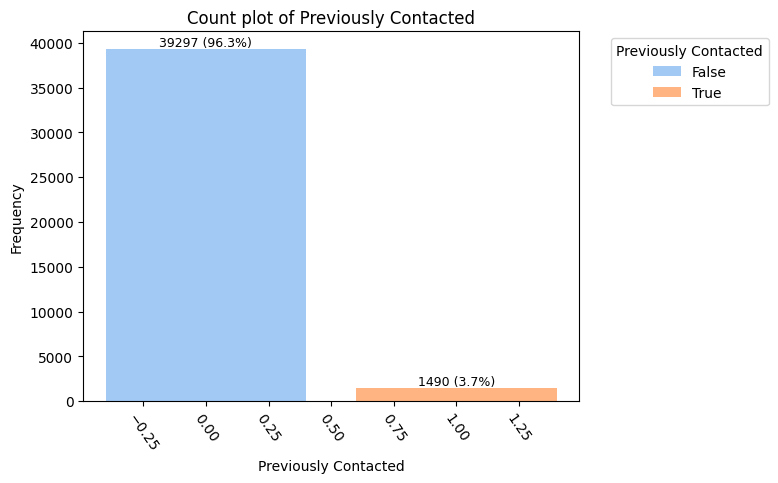

In [414]:
plot_bar_graph(df, col="Previously Contacted", kind="count", x_rotation=-55)

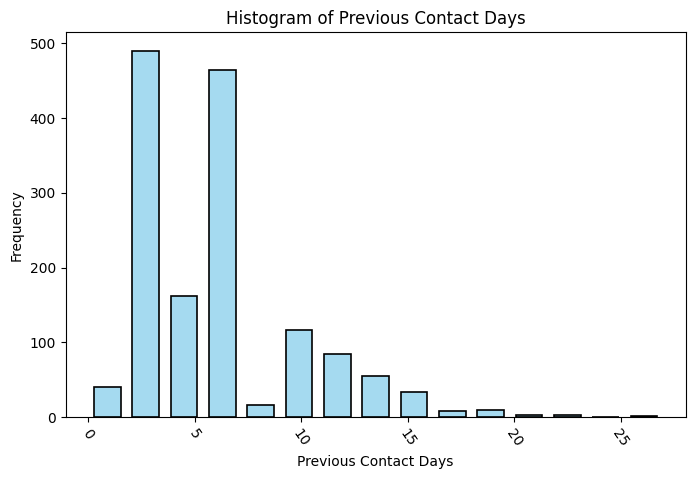

In [415]:
plot_hist_graph(
    df[df["Previous Contact Days"] != -1],
    col="Previous Contact Days",
    bins=15,
    shrink=0.7,
    x_rotation=-55,
)

In [416]:
columns = df.columns.tolist()
columns.remove("Subscription Status")
columns.append("Subscription Status")
df = df.reindex(columns=columns)
df.head()

,Age,Occupation,Marital Status,Education Level,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Previously Contacted,Subscription Status
0,57,technician,married,high.school,no,yes,cellular,1,-1,False,no
2,33,blue-collar,married,basic.9y,no,no,cellular,1,-1,False,no
3,36,admin.,married,high.school,no,no,telephone,4,-1,False,no
4,27,housemaid,married,high.school,None,no,cellular,2,-1,False,no
5,58,retired,married,professional.course,None,yes,cellular,1,-1,False,no


`Previously Contacted`: False means no prior contact (999) | True means there is contact

`Previous Contact Days`: 999 converted to -1

> **Observation:**
___

- Thre is a huge imbalance of Previously Contacted column, where very low numbers of clients have prior contact.
- The Previous Contact Days columns show a bimodel distribution.
- Highest is 3 calls with 431 rows and second highest is 6 calls with 404 rows.

> **THOUGHT PROCESS:**
___

- Although it seems like there is only 3.7% with prior contact, dropping the column may not be an ideal choice since it can still give meaningful insights.

##### Data Cleaning on `Subscription Status` Column

In [417]:
# Convert yes to True and no to False
df["Subscription Status"] = df["Subscription Status"].map(
    lambda x: True if x == "yes" else False
)
df.dtypes

Age                       int64
Occupation               object
Marital Status           object
Education Level          object
Housing Loan             object
Personal Loan            object
Contact Method           object
Campaign Calls            int64
Previous Contact Days     int64
Previously Contacted       bool
Subscription Status        bool
dtype: object

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40787 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    40787 non-null  int64 
 1   Occupation             40787 non-null  object
 2   Marital Status         40787 non-null  object
 3   Education Level        40787 non-null  object
 4   Housing Loan           16243 non-null  object
 5   Personal Loan          36679 non-null  object
 6   Contact Method         40787 non-null  object
 7   Campaign Calls         40787 non-null  int64 
 8   Previous Contact Days  40787 non-null  int64 
 9   Previously Contacted   40787 non-null  bool  
 10  Subscription Status    40787 non-null  bool  
dtypes: bool(2), int64(3), object(6)
memory usage: 3.2+ MB


#### Simple Data Imputation Analysis

##### Simple Imputation on `Age` Column

In [419]:
df_mean_rp = df.copy()
df_not_150 = df[df["Age"] != 150]["Age"]  # Retrieve rows without 150 to calculate mean
# impute 150 with the average age
df_mean_rp["Age_mean"] = df["Age"].apply(
    lambda x: df_not_150.agg("mean") if x == 150 else x
)
df_mean_rp["Age_mean"].head()

0    57.0
2    33.0
3    36.0
4    27.0
5    58.0
Name: Age_mean, dtype: float64

In [420]:
df_not_150.agg("mean")

np.float64(39.97881517881518)

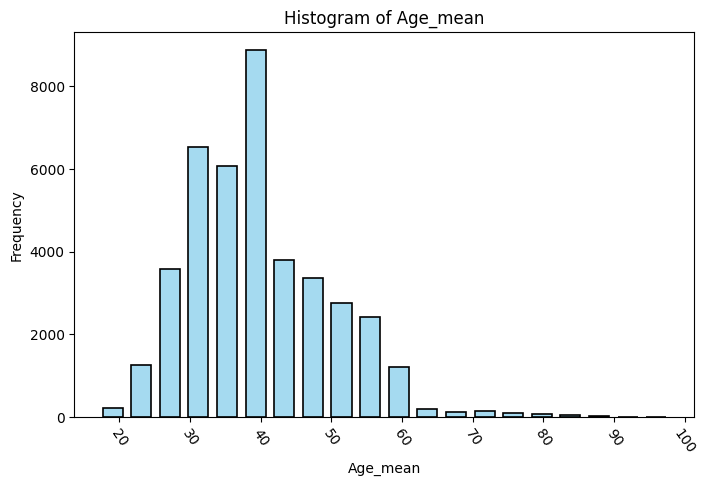

In [421]:
plot_hist_graph(
    df_mean_rp, col="Age_mean", bins=20, shrink=0.7, x_rotation=-55
)

In [422]:
df_median_rp = df.copy()

# Retrieve rows without 150 to calculate median
df_not_150 = df[df["Age"] != 150]["Age"]
df_median_rp["Age_median"] = df["Age"].apply(
    lambda x: df_not_150.agg("median") if x == 150 else x
)

# impute 150 with the middle age
df_median_rp["Age_median"].head()

0    57.0
2    33.0
3    36.0
4    27.0
5    58.0
Name: Age_median, dtype: float64

In [423]:
df_not_150.agg("median")

np.float64(38.0)

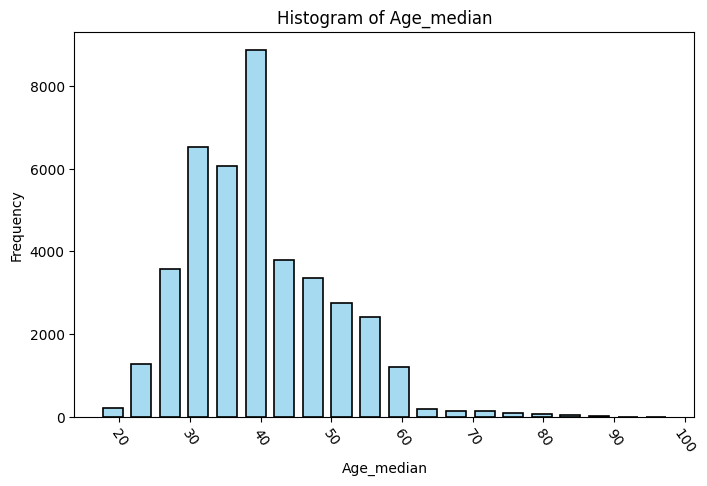

In [424]:
plot_hist_graph(
    df_median_rp, col="Age_median", bins=20, shrink=0.7, x_rotation=-55
)

> **Observation:**
___

- Both mean and median imputation were able to derive to the same distribution since both are approximately 38 to 39 years old.

- This shifted the distribution slightly to the center, distorting its original shape.

> **THOUGHT PROCESS:**
___

1. In order to maintain the original shape of distribution, I decided that mean and median may not be the best so I may utilize random distribution imputation instead.

#### Check relationships

In [425]:
def ohe_encode(df: pd.DataFrame) -> pd.DataFrame:
    """
    One hot encode all object type columns in input DataFrame

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    encoder = OneHotEncoder(sparse_output=False)
    df_copy = df.copy()

    # Initiate Dataframe with same number of rows
    df_encode = pd.DataFrame(index=df_copy.index)

    for col in df_copy.columns:
        if df_copy[col].dtype == "object":
            encoded = encoder.fit_transform(df_copy[[col]])

            # Get ohe column value names
            value_col = encoder.get_feature_names_out([col])
            encoded_columns = pd.DataFrame(
                encoded, columns=value_col, index=df_copy.index
            )
            df_encode = pd.concat([df_encode, encoded_columns], axis=1)
        else:
            df_encode[col] = df_copy[col]
    return df_encode


def int_encode(df):
    encoder = LabelEncoder()
    df_copy = df.copy()

    # Initiate Dataframe with same number of rows
    df_encode = pd.DataFrame(index=df_copy.index)

    for col in df_copy.columns:
        if df_copy[col].dtype == "object":
            df_encode[col] = encoder.fit_transform(df_copy[col])
        else:
            df_encode[col] = df_copy[col]
    return df_encode

##### Little MCAR Test

In [426]:
columns_na = df.columns[df.isna().any()]
for col in columns_na:
    print(f"{col}'s NaN no.: {df[col].isna().sum()}")

Housing Loan's NaN no.: 24544
Personal Loan's NaN no.: 4108


In [427]:
df_encode_mcar = int_encode(df)
columns_na = df_encode_mcar.columns[df.isna().any()]
for col in columns_na:
    # Convert 3 back to nan since nan was converted
    df_encode_mcar[col] = df_encode_mcar[col].map(lambda x: np.nan if x == 3 else x)

    # Check if number of nan is correct
    print(f"{col}'s values no.: {df_encode_mcar[col].isna().sum()}")

Housing Loan's values no.: 24544
Personal Loan's values no.: 4108


In [428]:
mcar_test = MCARTest()
results = mcar_test.little_mcar_test(df_encode_mcar)
results

Method: Little's MCAR Test
Test Statistic p-value: 0.129272
Decision: Fail to reject the null hypothesis (α = 0.05)
→ There is insufficient evidence to reject MCAR.


np.float64(0.129272233398945)

In [429]:
mcar_test = MCARTest()
results = mcar_test.little_mcar_test(df_encode_mcar.drop("Housing Loan", axis=1))
results

Method: Little's MCAR Test
Test Statistic p-value: 0.853363
Decision: Fail to reject the null hypothesis (α = 0.05)
→ There is insufficient evidence to reject MCAR.


np.float64(0.8533634300872586)

In [430]:
df_encode_mcar_age_150_to_nan = df_encode_mcar.copy()
df_encode_mcar_age_150_to_nan["Age"] = df_encode_mcar_age_150_to_nan["Age"].map(
    lambda x: np.nan if x == 150 else x
)

In [431]:
mcar_test = MCARTest()
results = mcar_test.little_mcar_test(df_encode_mcar_age_150_to_nan)
results

Method: Little's MCAR Test
Test Statistic p-value: 0.124373
Decision: Fail to reject the null hypothesis (α = 0.05)
→ There is insufficient evidence to reject MCAR.


np.float64(0.12437348127431758)

> **Observation:**
___

- Using little MCAR Test, the p value is significantly large (> 0.05), indicating that the data are consistent with missing completely at random (MCAR)

- Even with replacing 150 to na in Age column, the p value is still high.

> **THOUGHT PROCESS:**
___

1. This means that the missingness patterns is independent.

2. Suggesting to utilize simple imputation such as mean, median or random distribution.

##### Mutual Information (MI) of Personal Loan

In [432]:
def bin_numeric(df, bins=10):
    df_bin = df.copy()

    # Select columns that are numbers
    numeric_cols = df.select_dtypes(include=["number"]).columns
    for col in numeric_cols:
        # Apply binning
        df_bin[col] = pd.qcut(df_bin[col], q=bins, duplicates="drop").astype("object")
    return df_bin

In [433]:
target = "Personal Loan"

# Convert continuous number to discrete values
bin_num_df = bin_numeric(df.dropna(subset=[target]))
df_encode_temp = int_encode(bin_num_df)
X_df_temp, y_temp = (
    df_encode_temp.drop([target, "Housing Loan", "Age"], axis=1),
    df_encode_temp[target],
)
print(X_df_temp.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36679 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Occupation             36679 non-null  int64
 1   Marital Status         36679 non-null  int64
 2   Education Level        36679 non-null  int64
 3   Contact Method         36679 non-null  int64
 4   Campaign Calls         36679 non-null  int64
 5   Previous Contact Days  36679 non-null  int64
 6   Previously Contacted   36679 non-null  bool 
 7   Subscription Status    36679 non-null  bool 
dtypes: bool(2), int64(6)
memory usage: 2.0 MB
None


In [434]:
nmi_scores = []

for col in X_df_temp.columns:  # Compare each column with target column
    X = X_df_temp[col]
    nmi_score = normalized_mutual_info_score(X, y_temp)
    nmi_scores.append(nmi_score)

In [435]:
nmi = pd.Series(nmi_scores)
nmi.index = X_df_temp.columns
nmi = nmi.rename(target).sort_values(ascending=False).round(4).reset_index()
nmi

,index,Personal Loan
0,Contact Method,0.0005
1,Occupation,0.0003
2,Education Level,0.0001
3,Campaign Calls,0.0001
4,Marital Status,0.0001
5,Subscription Status,0.0000
6,Previously Contacted,0.0000
7,Previous Contact Days,0.0000


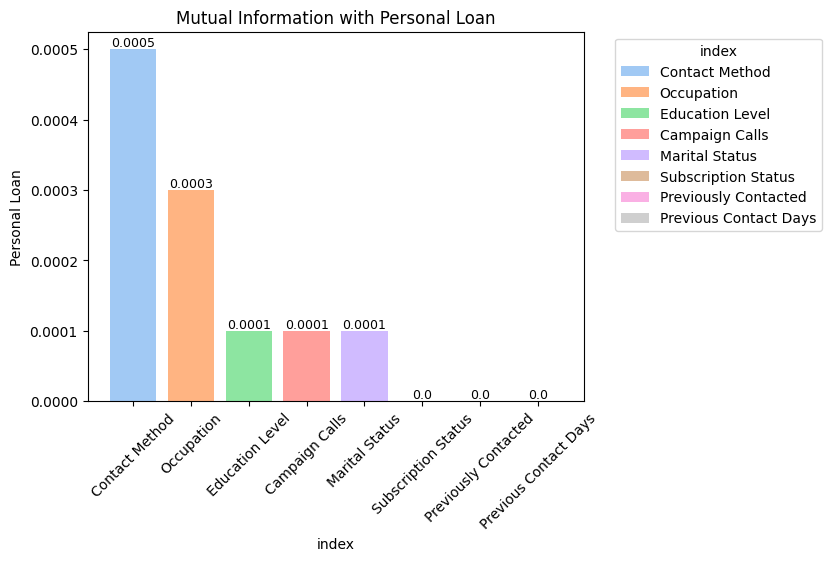

In [436]:
plot_bar_graph(
    nmi,
    col="index",
    y=target,
    kind="bar",
    title=f"Mutual Information with {target}",
    x_rotation=45,
)

> **Observation:**
___

- All the normalized mutual information values are very low.
- The highest correlation is only 0.0005 between Personal Loan and Previous Contact Days.
- While the remaining are less than 0.0003.
- Especially, correlation between Personal Loan and Subscription Status is very low.

> **THOUGHT PROCESS:**
___

1. Although, the correlation with Previous Contact Days is highest with 0.0005.

2. The remaining are all very little correlation, meaning the other columns carry minimal information about Personal Loan, model based imputation may not be an ideal choice.

3. The normalized MI tells me that Personal Loan can only be impute independently, so possibly usage of random distribution.

4. Since Personal Loan is also surprisingly low correlation with Subscription Status, it is also a choice to drop the column for feature selection if the team decides to.

##### Mutual Information (MI) of Housing Loan

In [437]:
target = "Housing Loan"
bin_num_df = bin_numeric(df.dropna(subset=[target]))
df_encode_temp = int_encode(bin_num_df)
X_df_temp, y_temp = (
    df_encode_temp.drop([target, "Personal Loan", "Age"], axis=1),
    df_encode_temp[target],
)
print(X_df_temp.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16243 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Occupation             16243 non-null  int64
 1   Marital Status         16243 non-null  int64
 2   Education Level        16243 non-null  int64
 3   Contact Method         16243 non-null  int64
 4   Campaign Calls         16243 non-null  int64
 5   Previous Contact Days  16243 non-null  int64
 6   Previously Contacted   16243 non-null  bool 
 7   Subscription Status    16243 non-null  bool 
dtypes: bool(2), int64(6)
memory usage: 920.0 KB
None


In [438]:
nmi_scores = []

for col in X_df_temp.columns:
    X = X_df_temp[col]
    nmi_score = normalized_mutual_info_score(X, y_temp)
    nmi_scores.append(nmi_score)

In [439]:
nmi = pd.Series(nmi_scores)
nmi.index = X_df_temp.columns
nmi = nmi.rename(target).sort_values(ascending=False).round(4).reset_index()
nmi

,index,Housing Loan
0,Contact Method,0.0033
1,Occupation,0.0005
2,Campaign Calls,0.0003
3,Education Level,0.0003
4,Marital Status,0.0002
5,Subscription Status,0.0001
6,Previously Contacted,0.0000
7,Previous Contact Days,0.0000


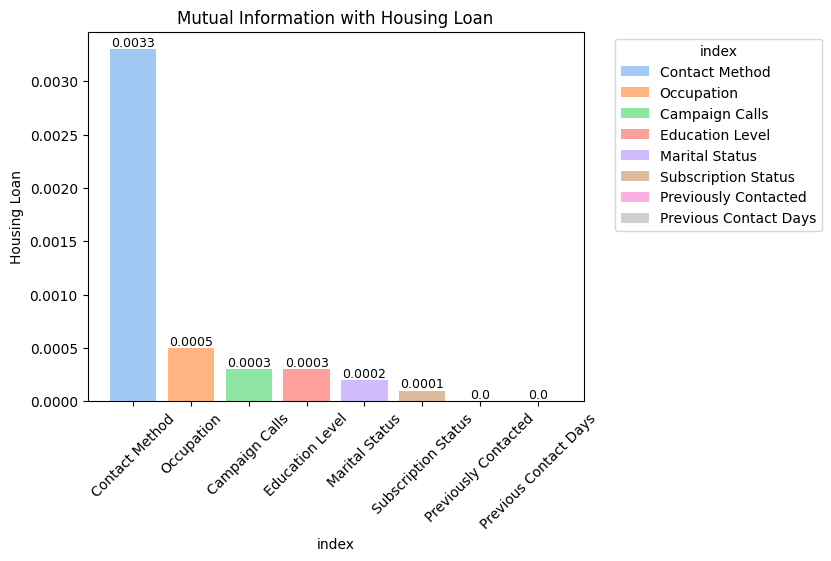

In [440]:
plot_bar_graph(
    nmi,
    col="index",
    y=target,
    kind="bar",
    title=f"Mutual Information with {target}",
    x_rotation=45,
)

> **Observation:**
___

- All the normalized mutual information values are very low.

> **THOUGHT PROCESS:**
___

1. Although, the correlation with Previous Contact Days is highest with 0.0033.

2. The remaining are all very little correlation, meaning the other columns carry minimal information about Personal Loan, model based imputation may not be an ideal choice.

3. The normalized MI tells me that Housing Loan can only be impute independently, so possibly usage of random distribution.

4. Since Housing Loan also has very low correlation with Subscription Status, it is a choice to drop the column for feature selection if the team decides to.

##### Mutual Information (MI) of Age

In [441]:
def bin_numeric(df, bins=10):
    df_bin = df.copy()
    numeric_cols = df.select_dtypes(include=["number"]).columns
    for col in numeric_cols:
        df_bin[col] = pd.qcut(df_bin[col], q=bins, duplicates="drop").astype("object")
    return df_bin

In [442]:
target = "Age"
bin_num_df = bin_numeric(df[df["Age"] != 150])
df_encode_temp = int_encode(bin_num_df)
X_df_temp, y_temp = (
    df_encode_temp.drop([target, "Housing Loan", "Personal Loan"], axis=1),
    df_encode_temp[target],
)
print(X_df_temp.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36630 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Occupation             36630 non-null  int64
 1   Marital Status         36630 non-null  int64
 2   Education Level        36630 non-null  int64
 3   Contact Method         36630 non-null  int64
 4   Campaign Calls         36630 non-null  int64
 5   Previous Contact Days  36630 non-null  int64
 6   Previously Contacted   36630 non-null  bool 
 7   Subscription Status    36630 non-null  bool 
dtypes: bool(2), int64(6)
memory usage: 2.0 MB
None


In [443]:
nmi_scores = []

for col in X_df_temp.columns:
    X = X_df_temp[col]
    nmi_score = normalized_mutual_info_score(X, y_temp)
    nmi_scores.append(nmi_score)

In [444]:
nmi = pd.Series(nmi_scores)
nmi.index = X_df_temp.columns
nmi = nmi.rename(target).sort_values(ascending=False).round(4).reset_index()
nmi

,index,Age
0,Marital Status,0.0700
1,Occupation,0.0581
2,Education Level,0.0210
3,Subscription Status,0.0054
4,Previously Contacted,0.0037
5,Contact Method,0.0023
6,Campaign Calls,0.0004
7,Previous Contact Days,0.0000


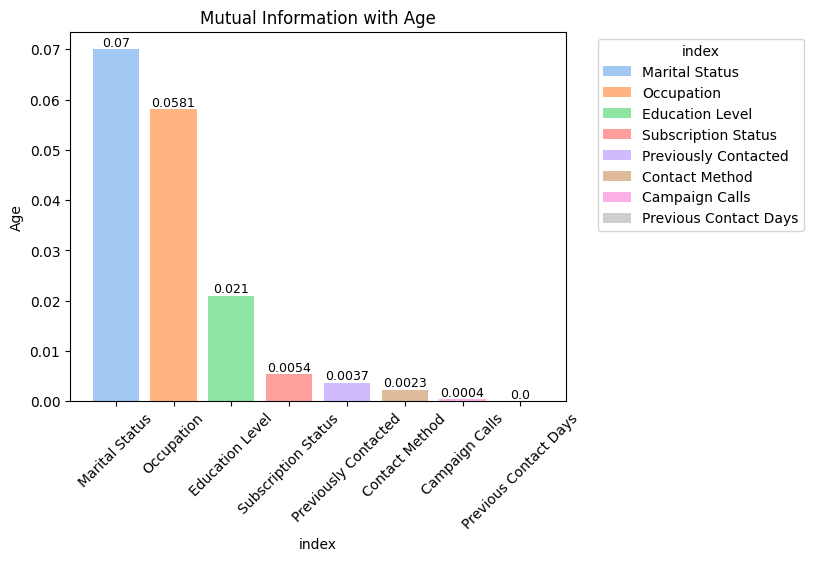

In [445]:
plot_bar_graph(
    nmi,
    col="index",
    y=target,
    kind="bar",
    title=f"Mutual Information with {target}",
    x_rotation=45,
)

> **Observation:**
___

- All the normalized mutual information values are also low.

> **THOUGHT PROCESS:**
___

1. The normalized MI tells me that Age may require to impute independently.
2. With support of previous analysis like simple imputation and little MCAR test random distribution may be the solution.
3. Imputing with KNN may also be an available choice, however, due to the low MI score, the output may be weak.

#### Decided Missing Data Solution for Age, Housing Loan & Personal Loan

In [446]:
df_new = df.drop("Housing Loan", axis=1)  # Drop Housing Loan
df_new.head()

,Age,Occupation,Marital Status,Education Level,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Previously Contacted,Subscription Status
0,57,technician,married,high.school,yes,cellular,1,-1,False,False
2,33,blue-collar,married,basic.9y,no,cellular,1,-1,False,False
3,36,admin.,married,high.school,no,telephone,4,-1,False,False
4,27,housemaid,married,high.school,no,cellular,2,-1,False,False
5,58,retired,married,professional.course,yes,cellular,1,-1,False,False


In [447]:
def random_distribution(df):
    df_temp = df.copy()
    targets = {"Age": 150, "Personal Loan": "none"}
    rng = np.random.default_rng(42)

    if not isinstance(df, pd.DataFrame):
        raise TypeError("Submitted dataframe is not a pd.DataFrame")

    for target, val in targets.items():
        col = df_temp[target]

        if val == "none":  # When the goal is to impute nan
            temp_col = col[~col.isna()]
            tobe_fill = col.isna()

        else:  # When the goal is to impute specific value
            temp_col = col[col != val]
            tobe_fill = col == val

        # Retrieve distribution of values
        distribution = temp_col.value_counts(normalize=True).tolist()
        labels = temp_col.value_counts().index.tolist()
        fill_mask = tobe_fill

        # Randomly assign target values with other unique values based on distrinbution
        fill = rng.choice(labels, size=fill_mask.sum(), p=distribution)
        df_temp.loc[fill_mask, target] = fill

    return df_temp

In [448]:
df_new = random_distribution(df_new)
df_new.head()

,Age,Occupation,Marital Status,Education Level,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Previously Contacted,Subscription Status
0,57,technician,married,high.school,yes,cellular,1,-1,False,False
2,33,blue-collar,married,basic.9y,no,cellular,1,-1,False,False
3,36,admin.,married,high.school,no,telephone,4,-1,False,False
4,27,housemaid,married,high.school,no,cellular,2,-1,False,False
5,58,retired,married,professional.course,yes,cellular,1,-1,False,False


In [449]:
df_new["Age"][df_new["Age"] == 150].sum()

np.int64(0)

In [450]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40787 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    40787 non-null  int64 
 1   Occupation             40787 non-null  object
 2   Marital Status         40787 non-null  object
 3   Education Level        40787 non-null  object
 4   Personal Loan          40787 non-null  object
 5   Contact Method         40787 non-null  object
 6   Campaign Calls         40787 non-null  int64 
 7   Previous Contact Days  40787 non-null  int64 
 8   Previously Contacted   40787 non-null  bool  
 9   Subscription Status    40787 non-null  bool  
dtypes: bool(2), int64(3), object(5)
memory usage: 2.9+ MB


In [451]:
# Old Personal Loan
print(df["Personal Loan"].unique())
df["Personal Loan"].value_counts(normalize=True)

['yes' 'no' None 'unknown']


Personal Loan
no         0.824150
yes        0.152076
unknown    0.023774
Name: proportion, dtype: float64

In [452]:
# New Personal Loan
print(df_new["Personal Loan"].unique())
df_new["Personal Loan"].value_counts(normalize=True)

['yes' 'no' 'unknown']


Personal Loan
no         0.824650
yes        0.151494
unknown    0.023856
Name: proportion, dtype: float64

### Numeric Correlation

                            Age  Campaign Calls  Previous Contact Days
Age                    1.000000        0.004586               0.016419
Campaign Calls         0.004586        1.000000              -0.043937
Previous Contact Days  0.016419       -0.043937               1.000000


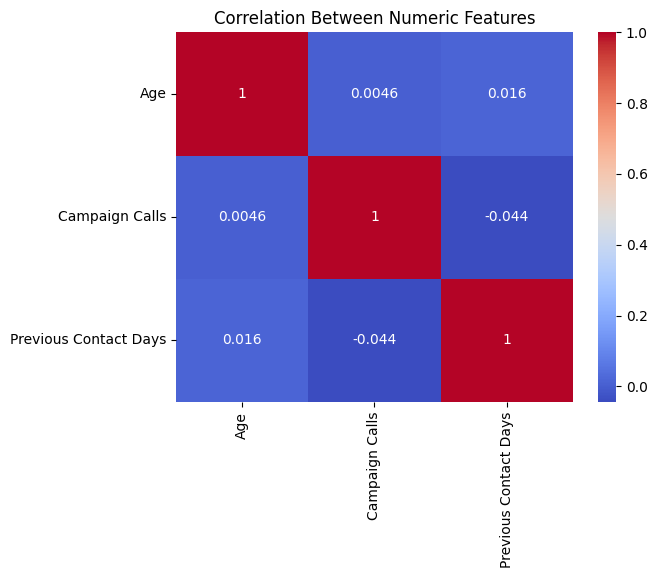

In [453]:
numeric_cols = ["Age", "Campaign Calls", "Previous Contact Days"]

# Using pairwise heatmap
corr_matrix = df_new[numeric_cols].corr()
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Numeric Features")
plt.show()

> **Observation:**
___

- Overall, the numeric columns have are very low correlation.

- Age compared to Campaign Calls and Previous Contact Days have a slight positive correlation, with 0.0033 and 0.022 repsectively.

- Campaign Calls and Previous Contact Days have a slight negative correlation with -0.044

> **THOUGHT PROCESS:**
___

1. This shows that the numeric columns have non-linear relationship between them.

2. The columns are mostly independent of one another.

### Mutual Information

In [454]:
def bin_numeric(df, bins=10):
    df_bin = df.copy()

    # Select columns that are numbers
    numeric_cols = df.select_dtypes(include=["number"]).columns
    for col in numeric_cols:
        # Apply binning
        df_bin[col] = pd.qcut(df_bin[col], q=bins, duplicates="drop").astype("object")
    return df_bin


def mutual_information_matrix(df, figsize=(12, 10)):
    cols = df.columns
    n = len(cols)

    # Initialize matrix
    nmi_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)

    # Compute normalized MI for each pair
    for i in range(n):
        for j in range(i, n):
            x = df[cols[i]]
            y = df[cols[j]]

            nmi = normalized_mutual_info_score(x, y, average_method="arithmetic")

            nmi_matrix.iloc[i, j] = nmi
            nmi_matrix.iloc[j, i] = nmi

    plt.subplots(figsize=figsize)
    sns.heatmap(nmi_matrix, annot=True, fmt=".4f", cmap="viridis", square=True)
    plt.title("Mutual Information Heatmap")

    plt.show()

    return nmi_matrix

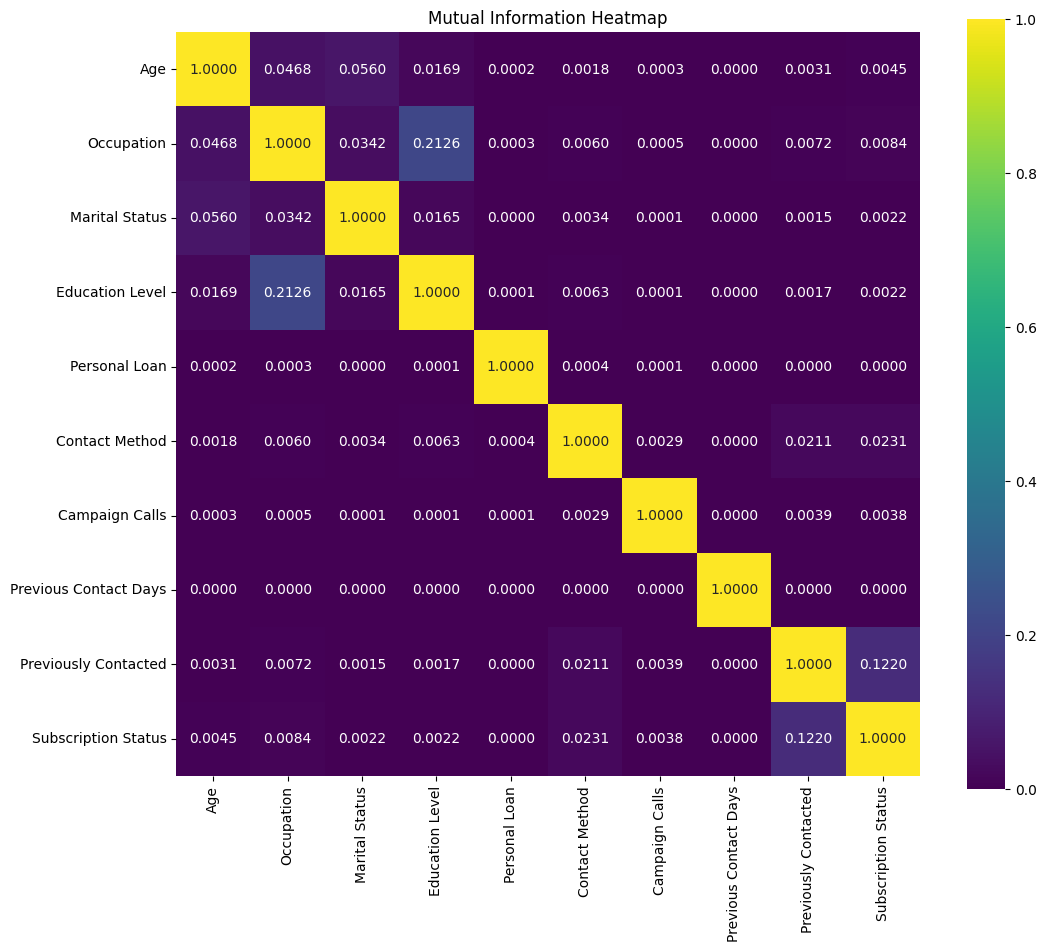

                            Age  Occupation  Marital Status  Education Level  \
Age                    1.000000    0.046783        0.055965         0.016941   
Occupation             0.046783    1.000000        0.034160         0.212573   
Marital Status         0.055965    0.034160        1.000000         0.016468   
Education Level        0.016941    0.212573        0.016468         1.000000   
Personal Loan          0.000166    0.000254        0.000023         0.000118   
Contact Method         0.001830    0.006033        0.003431         0.006278   
Campaign Calls         0.000300    0.000545        0.000119         0.000134   
Previous Contact Days  0.000000    0.000000        0.000000         0.000000   
Previously Contacted   0.003101    0.007153        0.001543         0.001723   
Subscription Status    0.004477    0.008366        0.002192         0.002218   

                       Personal Loan  Contact Method  Campaign Calls  \
Age                         0.000166        0.0

In [455]:
bin_num_df = bin_numeric(df_new)
encode_df = int_encode(bin_num_df)
mi_matrix = mutual_information_matrix(encode_df)
print(mi_matrix)

> **Observation:**
___

- The normalized mutual information (NMI) between the columns are mostly less than 0.01 correlation, meaning that the features are independent of one another.

- With one exception, where the NMI between Education Level and Occupation is 0.2165, which stands out, meaning both columns have higher correlation.

> **THOUGHT PROCESS:**
___

1. Overall, the columns are mostly independent of one another.
2. It makes sense for Occupation and Education Level to have higher correlation since they are similar in real world context.
3. Surprisingly, Previously Contacted has highest dependency with Subscription Status.
4. Previous Contact Days has no dependency with Subscription Status.

### Chi Square Test

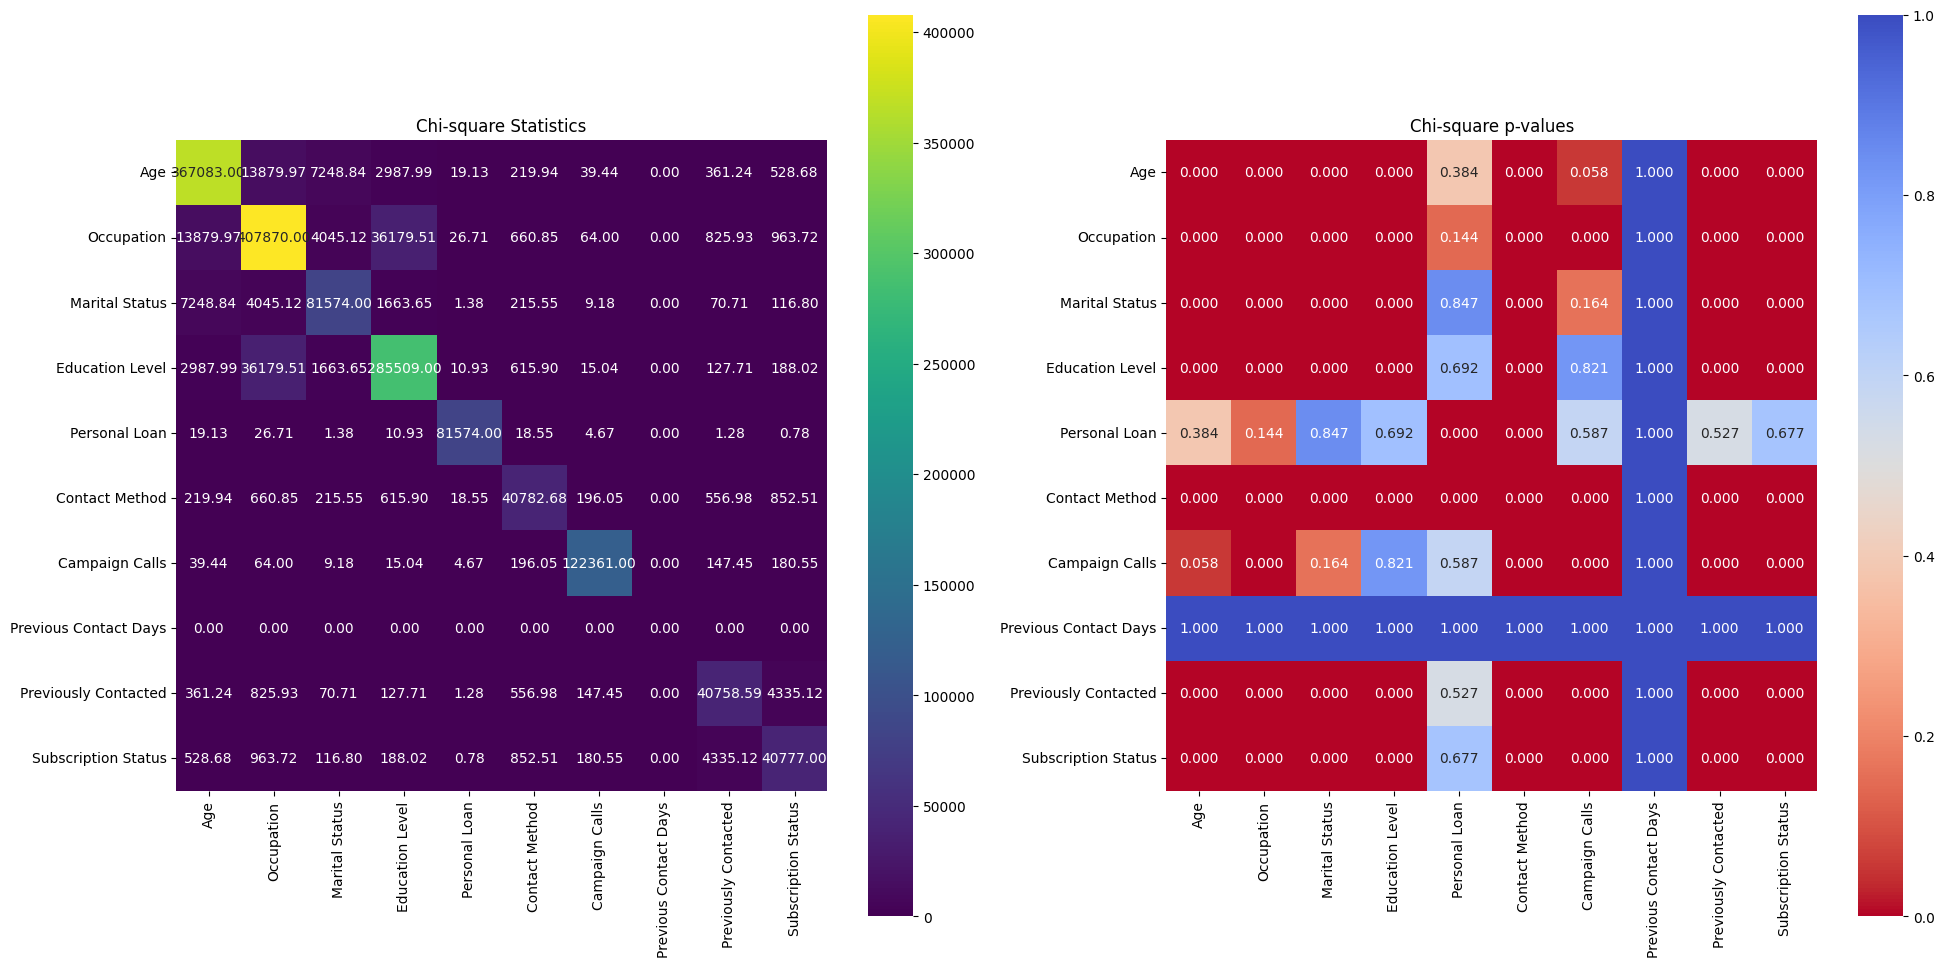

(                                 Age     Occupation  Marital Status  \
 Age                    367083.000000   13879.973705     7248.841217   
 Occupation              13879.973705  407870.000000     4045.117713   
 Marital Status           7248.841217    4045.117713    81574.000000   
 Education Level          2987.994996   36179.505595     1663.647637   
 Personal Loan              19.134928      26.711664        1.383333   
 Contact Method            219.939660     660.851162      215.549365   
 Campaign Calls             39.437752      63.995285        9.183562   
 Previous Contact Days       0.000000       0.000000        0.000000   
 Previously Contacted      361.238867     825.933649       70.714195   
 Subscription Status       528.677914     963.723715      116.802253   
 
                        Education Level  Personal Loan  Contact Method  \
 Age                        2987.994996      19.134928      219.939660   
 Occupation                36179.505595      26.711664    

In [456]:
def chi2_matrix(df):
    # Ensure only categorical columns
    cat_cols = df.select_dtypes(include=["object", "bool"]).columns
    n = len(cat_cols)

    chi2_matrix = pd.DataFrame(np.zeros((n, n)), index=cat_cols, columns=cat_cols)
    p_matrix = pd.DataFrame(np.zeros((n, n)), index=cat_cols, columns=cat_cols)

    # Compute chi square for each pair
    for i in range(n):
        for j in range(i, n):
            # contingency table
            table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
            chi2, p, dof, expected = chi2_contingency(table)

            chi2_matrix.iloc[i, j] = chi2
            chi2_matrix.iloc[j, i] = chi2
            p_matrix.iloc[i, j] = p
            p_matrix.iloc[j, i] = p

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.heatmap(
        chi2_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, ax=axes[0]
    )
    axes[0].set_title("Chi-square Statistics")

    sns.heatmap(
        p_matrix, annot=True, fmt=".3f", cmap="coolwarm_r", square=True, ax=axes[1]
    )
    axes[1].set_title("Chi-square p-values")

    plt.tight_layout()
    plt.show()

    return chi2_matrix, p_matrix


bin_num_df = bin_numeric(df_new)
chi2_matrix(bin_num_df)

> **Observation:**
___

- There is a similarity between chi square result and mutual information.
- Additionally, the p values of each pair of columns are mostly 0, meaning the columns are detected to have some dependency to each other.
- Previous Contact Days is 1 compared with other columns, especially with Subscription Status, meaning no evidence of association between columns.

> **THOUGHT PROCESS:**
___

1. The p values just shows whether any dependencies exist for the columns, while mutual information and chi square shows the strength of those dependencies.
2. Both mutual information and p values are suggesting to drop Previous Contact Days.
3. Though Personal Loan has high p values (0.7) suggesting that there is less evidence of association with Status Subscription. However, there is still some association and since other columns already have a low dependencies, it would be best to continue keeping Personal Loan to predict Subscription Status.

In [457]:
# Decided to drop Previous Contact Days
df_new.drop("Previous Contact Days", axis=1, inplace=True)

### Potential feature selection method

In [458]:
def my_train_test_split(
    df: pd.DataFrame, val_sample: bool = False, test_size: int = 0.2, rs: int = 42
) -> Union[
    Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series],
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series],
]:
    """
    Split input DataFrame into train, test and val(optional)

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame

    val_sample: bool
      State whether to generate validation data sample

    test_size: int
      State the size of test dataset

    rs: int
      Set random state for randomness
    """
    label = "Subscription Status"
    X, y = df.drop(label, axis=1), df[label]
    if val_sample:
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=test_size, random_state=rs, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=rs, stratify=y_temp
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=rs, stratify=y
        )
        return X_train, X_test, y_train, y_test

##### MI feature selection

In [459]:
X_train, X_test, y_train, y_test = my_train_test_split(df_new, test_size=0.3)
int_encoded_X = int_encode(X_train)
int_encoded_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28550 entries, 38914 to 39273
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   28550 non-null  int64
 1   Occupation            28550 non-null  int64
 2   Marital Status        28550 non-null  int64
 3   Education Level       28550 non-null  int64
 4   Personal Loan         28550 non-null  int64
 5   Contact Method        28550 non-null  int64
 6   Campaign Calls        28550 non-null  int64
 7   Previously Contacted  28550 non-null  bool 
dtypes: bool(1), int64(7)
memory usage: 1.8 MB


In [460]:
discrete_mask = [False, True, True, True, True, True, False, True]

target_mi_scores = mutual_info_classif(
    int_encoded_X, y_train, random_state=42, discrete_features=discrete_mask
)

In [461]:
target_mi = pd.Series(target_mi_scores)
target_mi.index = int_encoded_X.columns
target_mi = (
    target_mi.rename(y_train.name).sort_values(ascending=False).round(4).reset_index()
)
target_mi

,index,Subscription Status
0,Previously Contacted,0.0318
1,Contact Method,0.0109
2,Age,0.0103
3,Occupation,0.0093
4,Campaign Calls,0.0039
5,Education Level,0.0023
6,Marital Status,0.0010
7,Personal Loan,0.0000


In [462]:
# Utilize a feature selection technique to keep top k highest scoring features
select_cols = SelectKBest(k=5)
select_cols.scores_ = target_mi  # Pass Mutual Information score
select_cols.pvalues_ = None  # Reset P values
select_cols.fit(int_encoded_X, y_train)
int_encoded_X.columns[select_cols.get_support()]

Index(['Marital Status', 'Education Level', 'Contact Method', 'Campaign Calls',
       'Previously Contacted'],
      dtype='object')

In [463]:
# Utilize a feature selection technique to keep top percentage of features
select_cols = SelectPercentile(percentile=70)
select_cols.scores_ = target_mi  # Pass Mutual Information score
select_cols.pvalues_ = None  # Reset P values
select_cols.fit(int_encoded_X, y_train)
int_encoded_X.columns[select_cols.get_support()]

Index(['Marital Status', 'Education Level', 'Contact Method', 'Campaign Calls',
       'Previously Contacted'],
      dtype='object')

> **Observation:**
___

- With a clean dataset, I can proceed with a pre-feature selection making full use of mutual information.

- These are some features selected that can possibly maintain accuracy while reducing dimensionality.

##### MI feature selection (One Hot Encoded)

In [464]:
ohe_encoded_X = ohe_encode(X_train)
ohe_encoded_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28550 entries, 38914 to 39273
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  28550 non-null  int64  
 1   Occupation_admin.                    28550 non-null  float64
 2   Occupation_blue-collar               28550 non-null  float64
 3   Occupation_entrepreneur              28550 non-null  float64
 4   Occupation_housemaid                 28550 non-null  float64
 5   Occupation_management                28550 non-null  float64
 6   Occupation_retired                   28550 non-null  float64
 7   Occupation_self-employed             28550 non-null  float64
 8   Occupation_services                  28550 non-null  float64
 9   Occupation_student                   28550 non-null  float64
 10  Occupation_technician                28550 non-null  float64
 11  Occupation_unemployed        

In [465]:
target_mi_scores_ohe = mutual_info_classif(
    ohe_encoded_X, y_train, random_state=42, discrete_features="auto"
)

In [466]:
target_mi_ohe = pd.Series(target_mi_scores_ohe)
target_mi_ohe.index = ohe_encoded_X.columns
target_mi_ohe = (
    target_mi_ohe.rename(y_train.name)
    .sort_values(ascending=False)
    .round(4)
    .reset_index()
)
target_mi_ohe

,index,Subscription Status
0,Previously Contacted,0.0315
1,Contact Method_cellular,0.0159
2,Contact Method_telephone,0.0117
3,Age,0.0116
4,Occupation_blue-collar,0.0056
5,Education Level_university.degree,0.0048
6,Occupation_retired,0.0044
7,Campaign Calls,0.0043
8,Marital Status_divorced,0.0038
9,Occupation_student,0.0031


In [467]:
select_cols = SelectKBest(k=15)
select_cols.scores_ = target_mi_ohe
select_cols.pvalues_ = None
select_cols.fit(ohe_encoded_X, y_train)
ohe_encoded_X.columns[select_cols.get_support()]

Index(['Age', 'Occupation_admin.', 'Occupation_blue-collar',
       'Occupation_retired', 'Occupation_services', 'Occupation_student',
       'Marital Status_married', 'Marital Status_single',
       'Education Level_basic.6y', 'Education Level_basic.9y',
       'Education Level_university.degree', 'Contact Method_cellular',
       'Contact Method_telephone', 'Campaign Calls', 'Previously Contacted'],
      dtype='object')

In [468]:
select_cols = SelectPercentile(percentile=70)
select_cols.scores_ = target_mi_ohe
select_cols.pvalues_ = None
select_cols.fit(ohe_encoded_X, y_train)
ohe_encoded_X.columns[select_cols.get_support()]

Index(['Age', 'Occupation_admin.', 'Occupation_blue-collar',
       'Occupation_entrepreneur', 'Occupation_retired', 'Occupation_services',
       'Occupation_student', 'Occupation_unemployed',
       'Marital Status_divorced', 'Marital Status_married',
       'Marital Status_single', 'Education Level_basic.4y',
       'Education Level_basic.6y', 'Education Level_basic.9y',
       'Education Level_illiterate', 'Education Level_university.degree',
       'Education Level_unknown', 'Contact Method_cellular',
       'Contact Method_telephone', 'Campaign Calls', 'Previously Contacted'],
      dtype='object')

> **Observation:**
___

- In the scenario when one hot encoded is used on the dataset for model training.

- These are some features selected that can possibly maintain accuracy while reducing dimensionality as well.

## Pipeline function preparation

Preparing code to be added to Kedro pipeline

#### Clean data

In [469]:
def random_distribution(
    df: pd.DataFrame, target_col: str, target_val: Any = "none"
) -> pd.DataFrame:
    """
    Apply random distribution imputation to selected column

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame

    target_col: str
      Selected column to impute

    target_val: Any
      Selected value (data) to be impute
      input: "none" (default) or specific value from column
      example:
        "none"    : imputes all the np.nan or None in specified column
        150       : imputes all values with 150 in the specified column
        "unknown" : imputes all values with unknown in the specified column
    """
    df_temp = df.copy()
    rng = np.random.default_rng(42)
    col = df_temp[target_col]
    if target_val == "none":
        temp_col = col[~col.isna()]
        tobe_fill = col.isna()
    else:
        temp_col = col[col != target_val]
        tobe_fill = col == target_val
    distribution = temp_col.value_counts(normalize=True).tolist()
    labels = temp_col.value_counts().index.tolist()
    fill_mask = tobe_fill
    fill = rng.choice(labels, size=fill_mask.sum(), p=distribution)
    df_temp.loc[fill_mask, target_col] = fill
    return df_temp


def reindex_target_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Move position of Subscription Status column (target/label) to the back

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    cols = df.columns.tolist()
    cols.remove("Subscription Status")
    cols.append("Subscription Status")
    df_reorganized = df.reindex(columns=cols)
    return df_reorganized


def clean_clientId(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Client ID column
    Function action: Drop Client Id column

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.drop("Client ID", axis=1)
    return df_new


def clean_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Age column
    Function actions: Remove 'years' and keep the age number as integer,
    then apply random distribution imputation to Age column.

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_temp = df.copy()
    df_temp["Age"] = df_temp["Age"].map(lambda x: x.split()[0])
    df_temp["Age"] = df_temp["Age"].astype(int)
    df_new = random_distribution(df_temp, target_col="Age", target_val=150)
    return df_new


def clean_occupation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Occupation column
    Function action: Drop rows with 'unknown'

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.drop(df[df["Occupation"] == "unknown"].index, axis=0)
    return df_new


def clean_maritalStatus(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Marital Status column
    Function action: drop rows with 'unknown'

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.drop(df[df["Marital Status"] == "unknown"].index, axis=0)
    return df_new


def clean_creditDefault(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Credit Default column
    Function action: 'Drop Credit Default Column

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.drop("Credit Default", axis=1)
    return df_new


def clean_housingLoan(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Housing Loan column
    Function action: Drop Housing Loan Column

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.drop("Housing Loan", axis=1)
    return df_new


def clean_personalLoan(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Personal Loan column
    Function action: Apply random distribution imputation to Personal Loan column

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_temp = df.copy()
    df_new = random_distribution(df_temp, target="Personal Loan")
    return df_new


def clean_contactMethod(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Contact Method column
    Function action: Rename 'Cell' value with 'cellular' and 'Telephone' with 'telephone'

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.copy()
    df_new["Contact Method"] = df_new["Contact Method"].map(
        lambda x: "cellular" if x[0].lower() == "c" else "telephone"
    )
    return df_new


def clean_campaignCalls(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Campaign Calls column
    Function action: Absolute/Convert all negative values to positive

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.copy()
    df_new["Campaign Calls"] = df_new["Campaign Calls"].apply(lambda x: abs(x))
    return df_new


def clean_previousContactDays(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Previous Contact Days column
    Function action: Rename 999 to -1 and added a Previously Contacted column
                     as boolean:
                     False = no prior contact
                     True = got prior contact

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.copy()
    df_new["Previously Contacted"] = df_new["Previous Contact Days"] != 999
    df_new.drop("Previous Contact Days", axis=1, inplace=True)
    df_new = reindex_target_col(df_new)
    return df_new


def clean_subscriptionStatus(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Subscription Status column
    Function action: Rename 'yes' with 1 and 'no' with 0 and convert to boolean type

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_new = df.copy()
    df_new["Subscription Status"] = df_new["Subscription Status"].map(
        lambda x: True if x == "yes" else False
    )
    df_new["Subscription Status"] = df_new["Subscription Status"].astype(bool)
    return df_new

#### Encode data

In [470]:
def encoder_selection(encoder: str = "ohe") -> Union[OneHotEncoder, LabelEncoder]:
    """
    Select One Hot Encoding or Integer Encoding method

    parameters:
    -----------
    encoder: "ohe" (default) or "int"
      ohe: one hot encoding
      int: integer encoding
    """
    match encoder:
        case "ohe":
            encoder = OneHotEncoder()
        case "int":
            encoder = LabelEncoder()
        case _:
            raise ValueError("encoder must be 'ohe' or 'int'")
    return encoder


def ohe_encode(df: pd.DataFrame) -> pd.DataFrame:
    """
    One hot encode all object type columns in input DataFrame

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    encoder = encoder_selection("ohe")
    df_copy = df.copy()
    df_encode = pd.DataFrame(index=df_copy.index)

    for col in df_copy.columns:
        if df_copy[col].dtype == "object":
            encoded = encoder.fit_transform(df_copy[[col]])
            value_col = encoder.get_feature_names_out([col])
            encoded_df = pd.DataFrame(encoded, columns=value_col, index=df_copy.index)
            df_encode = pd.concat([df_encode, encoded_df], axis=1)
        else:
            df_encode[col] = df_copy[col]
    return df_encode


def int_encode(df: pd.DataFrame) -> pd.DataFrame:
    """
    Integer encode all object type columns in input DataFrame

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    encoder = encoder_selection("int")
    df_copy = df.copy()
    df_encode = pd.DataFrame(index=df_copy.index)

    for col in df_copy.columns:
        if df_copy[col].dtype == "object":
            df_encode[col] = encoder.fit_transform(df_copy[col])
        else:
            df_encode[col] = df_copy[col]
    return df_encode

#### Split Data

In [471]:
def my_train_test_split(
    df: pd.DataFrame, val_sample: bool = False, test_size: int = 0.2, rs: int = 42
) -> Union[
    Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series],
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series],
]:
    """
    Split input DataFrame into train, test and val(optional)

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame

    val_sample: bool
      State whether to generate validation data sample

    test_size: int
      State the size of test dataset

    rs: int
      Set random state for randomness
    """
    label = "Subscription Status"
    X, y = df.drop(label, axis=1), df[label]
    if val_sample:
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=test_size, random_state=rs, stratify=y
        )  # Use stratify for imbalance target values
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=rs, stratify=y_temp
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=rs, stratify=y
        )
        return X_train, X_test, y_train, y_test

#### Variation of data preparation

In [472]:
# Use SMOTE to balance training dataset
def smote(
    X_train: pd.DataFrame, y_train: pd.Series, rs: int = 42
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Apply SMOTE to training dataset

    paramters:
    ----------
    X_train: pd.DataFrame
      Input features training dataset

    y_train: pd.Series
      Input label training dataset

    rs: int
      Set random state for randomness
    """
    smote = SMOTE(random_state=rs)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    X_train_res, y_train_res = pd.DataFrame(X_train_res), pd.Series(y_train_res)
    return X_train_res, y_train_res


# Utilize KNNImputer
def my_knnimputer(
    df: pd.DataFrame,
    target_col: str,
    target_val: Any = None,
    corr_cols: list = None,
    n_neighbors: int = 5,
):
    """
    Impute target values such as missing data with KNN
    Ensure all columns in corr_cols are encoded or numeric

    paramters:
    ----------
    df: pd.DataFrame
      Input DataFrame

    target_col: str
      Column to be impute

    target_val: Any
      Value in target column to be impute

    corr_cols: list
      Correlated columns to assist in KNN imputation

    n_neighbors: int
      Set the number of similar groups (nearest neighbours) to look
      at when estimating a missing value.
    """
    df_copy = df.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)

    if target_val is not None:
        df_copy[target_col] = df_copy[target_col].map(
            lambda x: np.nan if x == target_val else x
        )

    if corr_cols is not None:
        final_corr_cols = (
            corr_cols if target_col in corr_cols else corr_cols.append(target_col)
        )
        df_copy[final_corr_cols] = imputer.fit_transform(df_copy[final_corr_cols])
    else:
        df_copy[target_col] = imputer.fit_transform(df_copy[[target_col]])

    return df_copy


# Vairant of clean age function (with knn)
def clean_age_with_knn(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning on Age column
    Function actions: Remove 'years' and keep the age number as integer,
    then apply KNN imputation to Age column.

    ! Correlated features selected to assist with imputation are (based on EDA Mutual Information):
      ['Occupation', 'Marital Status', 'Education Level',
      'Subscription Status','Previous Contact Days']

    !! Ensure cleaning for other columns are done, excluding the clean_age function,
    before using this function

    !!! This function auto encode the cleaned data with int_encode before imputing

    parameters:
    -----------
    df: pd.DataFrame
      Input DataFrame
    """
    df_temp = df.copy()
    df_temp["Age"] = df_temp["Age"].map(lambda x: x.split()[0])
    df_temp["Age"] = df_temp["Age"].astype(int)

    corr_cols = ["Marital Status", "Occupation", "Education Level"]

    encoded_df = int_encode(df_temp[corr_cols].append("Age"))
    df_new["Age"] = my_knnimputer(
        encoded_df, target_col="Age", target_val=150, corr_cols=corr_cols
    )
    return df_new

## Conclusion

### Null Values Handling

- Missing Completely At Randome (MCAR) Test:
  - MissingNo
    - Dendrogram
    - Missing Matrix
    - Heatmap
  - Little MCAR Test
  - Mutual information on each column to be impute

These methods have been used to check whether they can be imputed using values from other columns. Therefore, I was able to pinpoint that the columns to be impute are considered as MCAR, has to be imputed independently

- Finalized techniques suggested to impute are:
  - Random Distribution
  - KNN

### Data Cleaning & Preparation on columns

- Dropped Columns:
  - Client ID
  - Credit Default
  - Housing Loan
  - Previous Contact Days

- Removed "unknown" values:
  - Occupation
  - Marital Status

- Feature Engineering:
  - Age (remove ‘years old’)
  - Campaign Calls (absolute negative values)

- Impute/Replace Values:
  - Age (150)
  - Personal Loan (nan)
  - Contact Method (cel & Telephone)
  - Subscription Status (yes & no)

- Split column to cretae new feature
  - Previous Contact Days

### Dependencies Analysis

- Pairwise Heatmap on numeric columns
- Mutual Information
- Chi Square Test with p values

### Additional Suggested Techniques that may help model training

- Feature Selection
  - Mutual information
    - selectKBest: ['Marital Status', 'Education Level', 'Contact Method', 'Campaign Calls',
       'Previously Contacted']
    - selectPercentile: ['Marital Status', 'Education Level', 'Contact Method', 'Campaign Calls',
       'Previously Contacted']
  - Mutual information for One Hot Encoded scenario:
    - selectKBest: ['Age', 'Occupation_admin.', 'Occupation_blue-collar',
       'Occupation_retired', 'Occupation_services', 'Occupation_student',
       'Marital Status_married', 'Marital Status_single',
       'Education Level_basic.6y', 'Education Level_basic.9y',
       'Education Level_university.degree', 'Contact Method_cellular',
       'Contact Method_telephone', 'Campaign Calls', 'Previously Contacted']
    - selectPercentile: ['Age', 'Occupation_admin.', 'Occupation_blue-collar',
       'Occupation_entrepreneur', 'Occupation_retired', 'Occupation_services',
       'Occupation_student', 'Occupation_unemployed',
       'Marital Status_divorced', 'Marital Status_married',
       'Marital Status_single', 'Education Level_basic.4y',
       'Education Level_basic.6y', 'Education Level_basic.9y',
       'Education Level_illiterate', 'Education Level_university.degree',
       'Education Level_unknown', 'Contact Method_cellular',
       'Contact Method_telephone', 'Campaign Calls', 'Previously Contacted']

- Counter imbalance dataset:
  - SMOTE